# Use VICET to Bound Odometry Errors in LOAM initialized from a moving platform

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-28 16:47:58.823470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 16:47:58.922780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-28 16:47:59.319517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-28 16:47:59.319570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-28 16:48:00.018523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 16:48:00.019481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 16:48:00.019807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 16:48:00.020094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


## Load HD Map from .ply File

In [54]:
import trimesh
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]

print(np.shape(submap))
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Load "Ground Truth" Poses provided in dataset

In [146]:
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #Kitware API specify offset as -134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32)
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)
poses_eul = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# print(poses_eul)

<IPython.core.display.Javascript object>


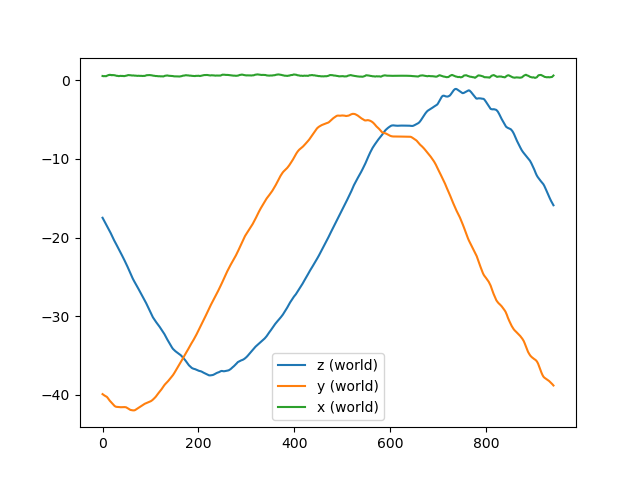

In [147]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
start_idx = 2400
end_idx = 3341

#plot GT
ax.plot(poses[start_idx:end_idx,:3,3], label={'x (world)',"y (world)","z (world)"})
# ax.plot(np.diff(poses[start_idx:end_idx,:3,3], axis = 0), label={'x',"y","z"})
# ax.plot(poses_eul)
# ax.plot(np.diff(poses_eul, axis=0))
ax.legend(loc="best")

## Load LOAM results (starting at arbitrary scan idx) and plot against ground truth

#### 05_00 (1670 frames) -> 05_01 (1671 frames) -> 05_02 (646 frames)

#### NOTE: axis will not be aligned!!!

<IPython.core.display.Javascript object>


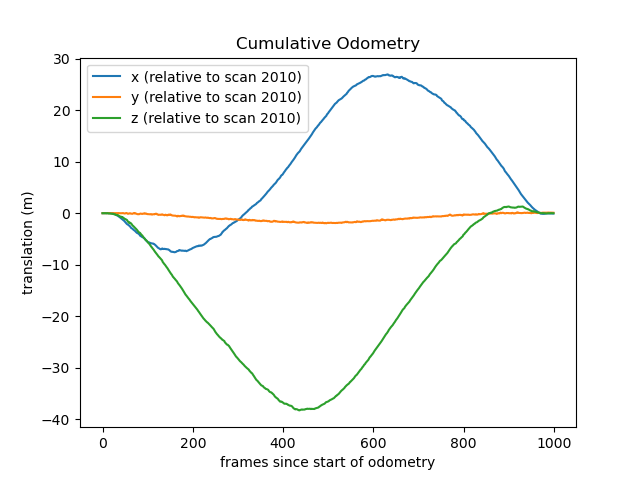

In [105]:
# fn = "results/LOAM/05_test1.npy" #before I got mapmaker working
# fn = "results/LOAM/05_test2.npy" #before I got mapmaker working

# 05_01 after reinstalling EVERYTHING and compiling pcl-1.10 from source
# fn = "results/LOAM/05_test3.npy" # 1650 long 
#makes odom estimates for overall frames 1690-3340 

# # rosbag play --clock -s 54 -r 0.05 rooster_2020-07-10-09-16-39_1.bag 
# fn = "results/LOAM/05_test4.npy" 

# # rosbag play --clock -s 55 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test5.npy" #1100 frames long, starts at 2241 

# # start at 2400- very obvious forward motion distortion ()
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test6.npy" #playback at 0.05x speed
# # fn = "results/LOAM/05_test7.npy" #playback at 0.2x speed (slightly worse)
# # fn_fast = "results/LOAM/05_test8.npy" #playback at 1.0x speed (bad)

# one lap of running around the quad starting from static position
# fn = "results/LOAM/05_LOAM_start_from_static.npy"
fn = "results/LOAM/05_LOAM_start_from_static_v2.npy"

LOAM_traj = np.load(fn)
# LOAM_traj = np.diff(np.load(fn), axis = 0)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(LOAM_traj[:,0], label = "x (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,1], label = "y (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,2], label = "z (relative to scan %i)" %start_idx)
ax.set_title("Cumulative Odometry")
ax.set_xlabel("frames since start of odometry")
ax.set_ylabel("translation (m)")
ax.legend(loc="best")

In [135]:
LOAM_traj =  LOAM_traj[10:,:]

# Plot GT and LOAM in 3D against HD Map 

### TODO: center map about first point in LOAM trajectory

In [106]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [107]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# start_idx = 2400 #overall of GT that corresponds to scan where LOAM begins
# end_idx = #3341
# start_idx = 2392
start_idx = 2020
end_idx = start_idx + len(LOAM_traj) #3341

#draw HD Map -------------------------------------------
# disp.append(Points(submap, c = "grey", r = 2, alpha = 0.1))

submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314

#draw ground truth trajectory -------------------------
# disp.append(Points(gt[start_idx:end_idx,2:5], c = "purple", r=3))#, alpha = 0.2)) #for debug

#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (initial_pose @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
disp.append(Points(gt_lidarframe[start_idx:end_idx,:3], c = "blue", r=3))#, alpha = 0.2))

#draw arrows showand provideding heading
for i in range(start_idx, end_idx,25):
    rot_m = R.from_quat(gt[i,5:]).as_matrix()
    arrow_ends = gt_lidarframe[i,:3] + np.linalg.pinv(rot_m) @ np.eye(3)
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[0,:], c='red'))
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[1,:], c='green'))
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[2,:], c='blue'))

#draw LOAM trajectory ----------------------------------
# disp.append(Points(LOAM_traj[:,:3], c = 'yellow', r = 3, alpha = 0.5))  #raw

# xyz = LOAM_traj[:,:3]
# LOAM_traj_lidarframe = np.array([LOAM_traj[:,0], LOAM_traj[:,1], LOAM_traj[:,2]]).T
LOAM_traj_lidarframe = np.array([LOAM_traj[:,0], LOAM_traj[:,2], LOAM_traj[:,1]]).T
xyz = LOAM_traj_lidarframe[:,:3]
qxyzw = R.from_euler('xyz', LOAM_traj[:,3:]).as_quat() #was this-- sooo close...

num_poses = qxyzw.shape[0]
poses_LOAM = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses_LOAM[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses_LOAM[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
# T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, :3] = R.from_euler('xyz', [0.0, 0., np.deg2rad(134.97 - 15)]).as_matrix() #manually fitting 05_test6 
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #test-flip signs
LOAM_mapframe = np.einsum("nij,jk->nik", poses_LOAM, T_CL)
# disp.append(Points(LOAM_mapframe[:,:3,3], c = 'red', r = 3, alpha = 0.5))

initial_pose_LOAM = np.linalg.pinv(LOAM_mapframe[0])
# print(initial_pose_LOAM)
# print("\n Initial  pose Map: \n", R.from_matrix(initial_pose[:3,:3]).as_euler("xyz"))
# print("\n Initial  pose LOAM: \n", R.from_matrix(initial_pose_LOAM[:3,:3]).as_euler("xyz"))

#draw axis for LOAM
# init_pose_map_euls = R.from_matrix(initial_pose[:3,:3]).as_euler("xyz")
init_pose_map_euls = R.from_matrix(initial_pose_LOAM[:3,:3]).as_euler("xyz")
# init_pose_map_euls[2] += np.deg2rad(45)#test
arrow_end = 3*np.eye(3) @ R.from_euler('xyz', init_pose_map_euls).as_matrix()
disp.append(Arrow([0,0,0], arrow_end[0], c='red'))
disp.append(Arrow([0,0,0], arrow_end[1], c='green'))
disp.append(Arrow([0,0,0], arrow_end[2], c='blue'))

#TODO: need to flip 180 degrees about LOAM frame y axis (remember LIDAR sensor coordinate system is flipped!)
axis = arrow_end[2] #rotate about y
# angle = np.deg2rad(180) #old
angle = np.deg2rad(90) #test
LOAM_mapframe2 = (rotation_matrix(axis, angle) @ LOAM_mapframe[:,:3].T).T
disp.append(Points(LOAM_mapframe2[:,:3,3], c = 'purple', r = 3, alpha = 0.5))

plt.show(disp, "LOAM vs Ground Truth")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Let's try that again from scratch

In [157]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
# start_idx = 2390 #for test 6, 7, 8
start_idx = 2010 #for new test (6/28)
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,0], c = 'red', alpha = 1))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,1], c = 'green', alpha = 1))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,2], c = 'blue', alpha = 1))
# disp.append(Points([[0.,0,0]], c='red', r =10))

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix() #was this for 678
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(28), 0]).as_matrix() #test
rot_mat = R.from_euler('xyz', [np.deg2rad(-3), np.deg2rad(28), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #for test 678
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
# gt_points = Points(gt_lidarframe[2200:3200,:3], c = "black", r=2).legend("Actual Motion of Platform")
gt_points = Points(gt_lidarframe[2000:3000,:3], c = "black", r=2).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,0], c = 'red', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,1], c = 'green', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,2], c = 'blue', alpha = 1.))
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 1).legend("LOAM Estimated Trajectory")
LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.2, r = 6).legend("LOAM Estimated Trajectory (Static Start)")
disp.append(LOAM_pts)


#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314


lb = LegendBox([gt_points, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left').font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [158]:
# %%bash 
# vedo -r fonts

<IPython.core.display.Javascript object>


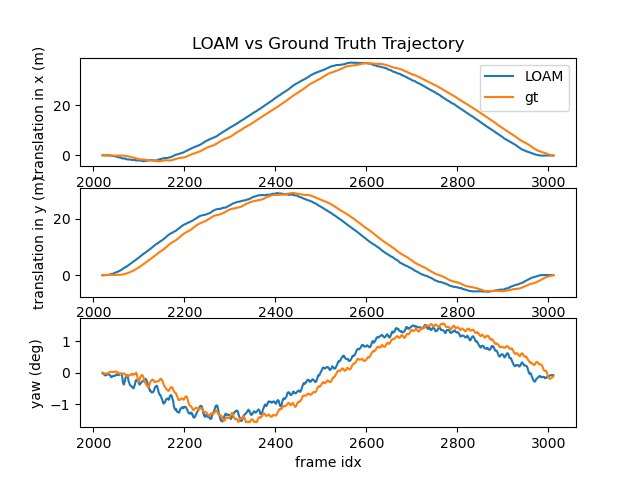

In [167]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3,1)
ax[0].set_title("LOAM vs Ground Truth Trajectory")

# x_vec = np.linspace(2240, 2241 + len(LOAM_corr), len(LOAM_corr) )
x_vec = np.linspace(2020, 2021 + len(LOAM_corr), len(LOAM_corr) )

ax[0].plot(x_vec, LOAM_corr[:,0], label = "LOAM")
ax[0].plot(x_vec, gt_lidarframe[start_idx:end_idx,0], label = "gt")
# ax[0].plot(np.diff(LOAM_corr[:,0]), label = "LOAM")
# ax[0].plot(np.diff(gt_lidarframe[start_idx+1:end_idx,0]), label = "gt")
ax[0].set_ylabel("translation in x (m)")
ax[0].legend(loc='best')
ax[1].set_ylabel("translation in y (m)")
ax[1].plot(x_vec, LOAM_corr[:,1], label = "LOAM")
ax[1].plot(x_vec, gt_lidarframe[start_idx:end_idx,1], label = "gt")

LOAM_yaw = np.arcsin(np.sin(LOAM_traj[:,4]))
gt_yaw = np.arcsin(np.sin(R.from_quat(gt[:, 5:]).as_euler('xyz')[:,2] + np.deg2rad(0)) )
# LOAM_yaw = np.rad2deg(np.arcsin(np.sin(LOAM_traj[:,4])))
# gt_yaw = np.rad2deg(np.arcsin(np.sin(R.from_quat(gt[:, 5:]).as_euler('xyz')[:,2] + np.deg2rad(105)) ))


ax[2].set_xlabel("frame idx")
# ax[2].set_ylabel("yaw (rad)")
ax[2].set_ylabel("yaw (deg)")
ax[2].plot(x_vec, LOAM_yaw, label = "LOAM")
ax[2].plot(x_vec, gt_yaw[start_idx-3:end_idx-3])

<IPython.core.display.Javascript object>


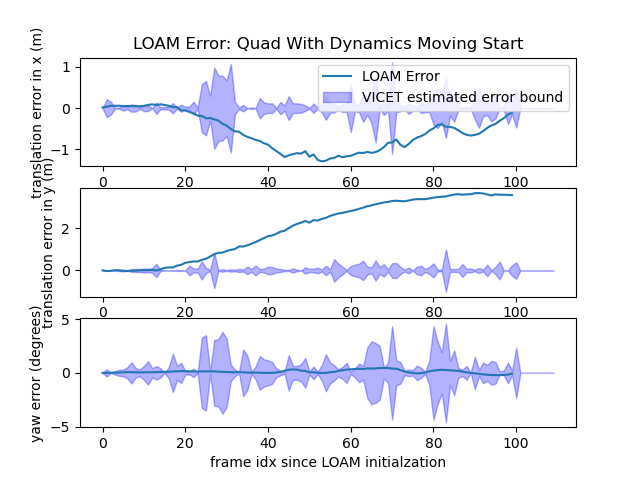

In [168]:
fig, ax = plt.subplots(3,1)
viewlen = 100 #view only this many frames since initialization
alph = 0.3
A_hist = np.load("results/LOAM/A_hist_05_test6.npy")

#TODO: transform A_hist from sensor body frame (for each scan) to init body frame
#      this will explain why x is too small, y is too big

ax[0].set_title("LOAM Error: Quad With Dynamics Moving Start")
ax[0].plot(LOAM_corr[:viewlen,0] - gt_lidarframe[start_idx:(start_idx + viewlen),0], label = "LOAM Error")
# ax[0].plot(LOAM_corr[10:viewlen,0] - gt_lidarframe[start_idx+10:(start_idx + viewlen),0])
ax[0].fill_between(x = np.linspace(0,len(A_hist)-1,len(A_hist)), 
                   y1 = abs(A_hist[:,7])/2, 
                   y2 = -abs(A_hist[:,7])/2,
                   color = 'blue', alpha = alph, label = "VICET estimated error bound")
ax[0].legend(loc='best')

ax[0].set_ylabel("translation error in x (m)")

ax[1].set_ylabel("translation error in y (m)")
ax[1].plot(LOAM_corr[:viewlen,1] - gt_lidarframe[start_idx:(start_idx+viewlen),1])
# ax[1].plot(LOAM_corr[10:viewlen,1] - gt_lidarframe[start_idx+10:(start_idx+viewlen),1])
ax[1].fill_between(x = np.linspace(0,len(A_hist)-1,len(A_hist)), 
                   y1 = abs(A_hist[:,8])/2, 
                   y2 = -abs(A_hist[:,8])/2,
                   color = 'blue', alpha = alph)

ax[2].set_ylabel("yaw error (degrees)")
ax[2].set_xlabel("frame idx since LOAM initialzation")
ax[2].plot(gt_yaw[start_idx:(start_idx + 100)] - LOAM_yaw[:100])
# ax[2].plot(np.rad2deg(gt_yaw[start_idx:(start_idx + 100)] - LOAM_yaw[:100]))
ax[2].fill_between(x = np.linspace(0,len(A_hist)-1,len(A_hist)), 
                   y1 = np.rad2deg(abs(A_hist[:,11])/2), 
                   y2 = np.rad2deg(-abs(A_hist[:,11])/2),
                   color = 'blue', alpha = alph)

# Use VICET to Estimate Error Bounds (single frame)

In [16]:
#load scans
# idx = 2400 #2700 #2650 #2000 - 3000 is the running and swinging loop
idx = 2400 #very obvious translation distortion
skip = 40 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 10 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# # idx = 116 #slow distortion, very accurate solution
# skip = 3 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#COLOR SCAN1 POINTS BY ORDER IN CLOUD
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
# disp.append(Points(pc1, c = cname, r = 3, alpha = 1))

#alt: transform pc2 to pc1 frame
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
# disp.append(Points(pc2, c = '#2c7c94', r = 3)) #blue
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_pc1_frame = (np.linalg.pinv(poses[idx]) @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T[:,:3]
# disp.append(Points(submap_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.1)) ##CB2314
plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
# plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [995]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 0.5 #was 2.5
SOLVER = '12_state' #VICET
# SOLVER = '6_state' #pins rigid transform in place (for debug only)

# dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 50, niter = 50, 
#         draw = True, mnp = 25, RM = False, solver = SOLVER, 
#         max_buffer = max_buffer, A0 = A0)

dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 80, niter = 50, 
        draw = True, mnp = 25, RM = True, solver = SOLVER, 
        max_buffer = max_buffer, A0 = A0)


ViewInteractiveWidget(dc.plt.window)

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [-0.1089 -0.0415  0.0355  0.014   0.0119 -0.0059] 
 [-0.0188  0.0091  0.0274 -0.0073 -0.0124  0.0051]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([508   3   3], shape=(3,), dtype=int32)

 residuals (1524, 1)

 delta_A
 (12,)
A: 
 [-0.1137 -0.0699  0.0329  0.0173  0.013  -0.0093] 
 [-0.0279  0.0344  0.1058 -0.0034 -0.0121  0.0092]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([509   3   3], shape=(3,), dtype=int32)

 residuals (1527, 1)

 delta_A
 (12,)
A: 
 [-0.1071 -0.0754  0.0162  0.0174  0.0108 -0.0095] 
 [-0.0165  0.0314  0.1687  0.0018 -0.0094  0.0079]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([513   3   3], shape=(3,), dtype=int32)

 residuals (1539, 1)

 delta_A
 (12,)
A: 
 [-0.1052 -0.0763 -0.0061  0.0165  0.0084 -0.0101] 
 [-0.0079  0.0246  0.2256  0.0068 -0.0066  0.0077]
~~~~~~~~~~~Iterat


 ---checking for moving objects---
LUT tf.Tensor([490   3   3], shape=(3,), dtype=int32)

 residuals (1470, 1)

 delta_A
 (12,)
A: 
 [-0.1247 -0.0902 -0.1312  0.0138 -0.0071 -0.0107] 
 [0.0328 0.1144 0.5073 0.032  0.023  0.0053]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [-0.1247 -0.0818 -0.1313  0.0137 -0.0073 -0.0096] 
 [0.0349 0.0973 0.5084 0.0323 0.0233 0.0027]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([491   3   3], shape=(3,), dtype=int32)

 residuals (1473, 1)

 delta_A
 (12,)
A: 
 [-0.1229 -0.1005 -0.13    0.0138 -0.0072 -0.0106] 
 [0.0296 0.1434 0.5051 0.0321 0.0234 0.0053]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([491   3   3], shape=(3,), dtype=int32)

 residuals (1473, 1)

 delta_A
 (12,)
A: 
 [-0.1236 -0.0816 -0.1316  0.0138 -0.0075 -0.0095] 
 [0.0358 0.1034 0

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [963]:
#debug: run VICET a bunch of times to look at spread of values for each param in A_hat
runlen = 30
A_hist = np.zeros([runlen,12])

for i in range(30):
    A0 = np.array([0., 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5
    SOLVER = '12_state' #VICET
    # SOLVER = '6_state' #pins rigid transform in place (for debug only)
    # scan to scan
    dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 80, niter = 50, 
            draw = False, mnp = 25, RM = True, solver = SOLVER, 
            max_buffer = max_buffer, A0 = A0)    
    A_hist[i,:] = dc.A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([618   3   3], shape=(3,), dtype=int32)

 residuals (1854, 1)

 delta_A
 (12,)
A: 
 [-0.0189  0.0092  0.0734 -0.0147  0.0001  0.0024] 
 [-0.0043 -0.0357 -0.0218 -0.0074 -0.0037  0.0021]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [-0.0251  0.0161  0.0705 -0.0137  0.0024  0.0046] 
 [ 0.003  -0.0404 -0.0297 -0.0113 -0.0063  0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([607   3   3], shape=(3,), dtype=int32)

 residuals (1821, 1)

 delta_A
 (12,)
A: 
 [-0.0271  0.0189  0.072  -0.0126  0.0034  0.0063] 
 [ 0.0114 -0.0456 -0.0402 -0.0142 -0.0072  0.0005]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([607   3   3], shape=(3,), dtype=int32)

 residuals (1821, 1)

 delta_A
 (12,)
A: 
 [-0.0274  0.0194  0.0723 -0.012   0.004   0.0076] 
 [ 0.0156 -0.0508 -0.0451 -0.0158 -0.0079 -0.0002]
~~~~~~~~~~~Iterat

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


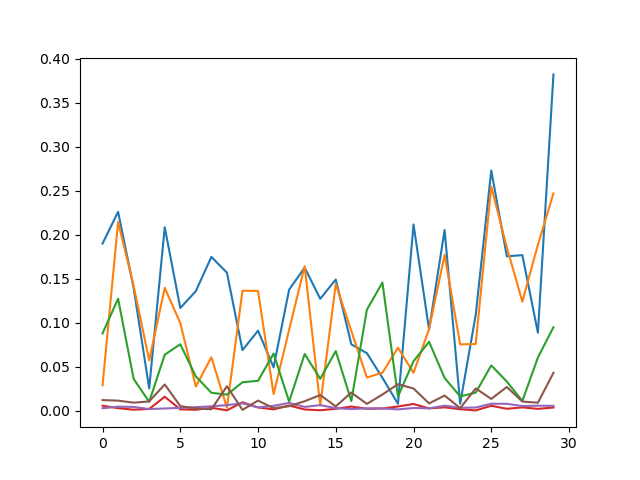

[0.13546165 0.10580484 0.05101487 0.00334742 0.00427667 0.0139063 ]


In [949]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

ax.plot(abs(A_hist[:,6:]))

print(np.mean(abs(A_hist[:,6:]), axis = 0))

# loop through 100 frame sequence

In [998]:
A_hist = np.zeros([110,12])
viewlen = 100

for i in range(1,viewlen + 1):
    print("\n \n Frame", i, "of 110 \n \n")
    
    #load scans
    idx = 2400 
    skip = i #how many lidar frames between clouds
    # (need to deal with how there are more LIDAR frames than ground truth poses)
    offset = 10 #10 #11  #works best for 05 dataset
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

    # idx = 950 #1080 #950 #fast motion
    # # idx = 116 #slow distortion, very accurate solution
    # skip = 3 #how many lidar frames between clouds
    # offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
    # fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

    pc1 = np.load(fn1)
    pc2 = np.load(fn2)
    #apply homogeneous transform matrix
    scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    # #Rotate scans to align beginning of each scan with +X axis ----------
    # #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    # #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    # #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    # scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
    # scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
    # submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
    # #--------------------------------------------------------------------
    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
    scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]
    

    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    
    #run VICET
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5
    SOLVER = '12_state' #VICET
#     SOLVER = '6_state' #pins rigid transform in place (for debug only)
    m_hat0 = np.array([0.0, 0.0, 0., 0., 0., 0.])

    #I think LIDARFRAME stuff is wrong actully...
#     dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 80, niter = 15, 
#         draw = False, mnp = 25, RM = True, solver = SOLVER, 
#         max_buffer = 2.5, A0 = A0, m_hat0 = m_hat0)
    dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 80, niter = 50, 
        draw = False, mnp = 25, RM = True, solver = SOLVER, 
        max_buffer = max_buffer, A0 = A0, m_hat0 = m_hat0)


    if SOLVER == '6_state':
        A_hist[i,6:] = dc.m_hat
    else:
        A_hist[i,:] = dc.A


 
 Frame 1 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([697   3   3], shape=(3,), dtype=int32)

 residuals (2091, 1)

 delta_A
 (12,)
A: 
 [-0.0064  0.0143 -0.0097  0.0015 -0.0049  0.0022] 
 [ 0.0177  0.0004 -0.0046 -0.0003  0.0006 -0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([700   3   3], shape=(3,), dtype=int32)

 residuals (2100, 1)

 delta_A
 (12,)
A: 
 [-0.0054  0.022  -0.013   0.0021 -0.0063  0.0025] 
 [ 0.0221 -0.0124  0.0052  0.0019  0.0012 -0.0009]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([700   3   3], shape=(3,), dtype=int32)

 residuals (2100, 1)

 delta_A
 (12,)
A: 
 [-0.0059  0.0293 -0.0162  0.0018 -0.0071  0.0022] 
 [ 0.0241 -0.0287  0.0142  0.0043  0.002  -0.    ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([700   3   3], shape=(3,), dtype=int32)

 residuals (2100, 1)

 delta_A
 (12,)
A: 
 [-0.007   0.0366 -0.0183  0.0014 -0.0078  0.002 ] 
 [ 0.0249 -0.0465  0.0211  0.0064  0.003   0.


 ---checking for moving objects---
LUT tf.Tensor([676   3   3], shape=(3,), dtype=int32)

 residuals (2028, 1)

 delta_A
 (12,)
A: 
 [ 0.0339  0.2086 -0.0164  0.0044 -0.007   0.0099] 
 [-0.0336 -0.3431  0.0245  0.0033 -0.0024 -0.0042]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([683   3   3], shape=(3,), dtype=int32)

 residuals (2049, 1)

 delta_A
 (12,)
A: 
 [ 0.0335  0.2125 -0.0169  0.0046 -0.0069  0.0103] 
 [-0.0213 -0.375   0.0256  0.0037 -0.0022 -0.0079]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([682   3   3], shape=(3,), dtype=int32)

 residuals (2046, 1)

 delta_A
 (12,)
A: 
 [ 0.0318  0.2193 -0.0169  0.0045 -0.0069  0.011 ] 
 [-0.0138 -0.4002  0.0215  0.0034 -0.002  -0.0109]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([681   3   3], shape=(3,), dtype=int32)

 residuals (2043, 1)

 delta_A
 (12,)
A: 
 [ 0.0321  0.2292 -0.0154  0.0045 -0.0071  0.0119] 


 ---checking for moving objects---
LUT tf.Tensor([683   3   3], shape=(3,), dtype=int32)

 residuals (2049, 1)

 delta_A
 (12,)
A: 
 [ 0.0239  0.0783 -0.0277  0.0021 -0.0173  0.0024] 
 [-0.0084 -0.126   0.0423  0.0277  0.0105  0.0045]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.0255  0.0829 -0.0248  0.0019 -0.0174  0.0027] 
 [-0.0115 -0.1358  0.0367  0.0279  0.0106  0.0039]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([682   3   3], shape=(3,), dtype=int32)

 residuals (2046, 1)

 delta_A
 (12,)
A: 
 [ 0.0274  0.0884 -0.0221  0.0018 -0.0175  0.0029] 
 [-0.0157 -0.1448  0.0314  0.028   0.0108  0.0038]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([680   3   3], shape=(3,), dtype=int32)

 residuals (2040, 1)

 delta_A
 (12,)
A: 
 [ 0.029   0.0948 -0.0199  0.0017 -0.0176  0.0034] 


 ---checking for moving objects---
LUT tf.Tensor([665   3   3], shape=(3,), dtype=int32)

 residuals (1995, 1)

 delta_A
 (12,)
A: 
 [ 0.0658  0.2051  0.0016  0.0032 -0.0139  0.0093] 
 [-0.0747 -0.2801 -0.0091  0.0256  0.0016  0.0034]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([671   3   3], shape=(3,), dtype=int32)

 residuals (2013, 1)

 delta_A
 (12,)
A: 
 [ 0.0663  0.2141 -0.0022  0.0029 -0.0137  0.0098] 
 [-0.0641 -0.3239  0.0053  0.0271  0.0007 -0.0011]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([664   3   3], shape=(3,), dtype=int32)

 residuals (1992, 1)

 delta_A
 (12,)
A: 
 [ 0.0664  0.2128 -0.0018  0.0027 -0.0137  0.0098] 
 [-0.0695 -0.3001 -0.0007  0.0265  0.0008  0.0016]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([668   3   3], shape=(3,), dtype=int32)

 residuals (2004, 1)

 delta_A
 (12,)
A: 
 [ 0.0652  0.2058 -0.0015  0.003  -0.0134  0.009 ] 


 ---checking for moving objects---
LUT tf.Tensor([646   3   3], shape=(3,), dtype=int32)

 residuals (1938, 1)

 delta_A
 (12,)
A: 
 [-0.0087  0.0011 -0.0294 -0.0017 -0.0097 -0.0002] 
 [ 0.0088 -0.0045  0.0703  0.0421  0.0128 -0.0046]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([644   3   3], shape=(3,), dtype=int32)

 residuals (1932, 1)

 delta_A
 (12,)
A: 
 [-0.0082  0.0008 -0.0277 -0.0016 -0.0096 -0.0002] 
 [ 0.0082 -0.003   0.0661  0.0419  0.0125 -0.0047]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [-0.0078  0.0015 -0.026  -0.0016 -0.0094 -0.0001] 
 [ 0.0074 -0.0037  0.0618  0.0415  0.0123 -0.0049]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [-0.0074  0.0032 -0.0246 -0.0016 -0.0093  0.    ] 

LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 residuals (1878, 1)

 delta_A
 (12,)
A: 
 [-0.0144  0.0062 -0.0205  0.0049 -0.0028  0.0012] 
 [ 0.0222 -0.051   0.0236  0.0108  0.0062 -0.0068]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([624   3   3], shape=(3,), dtype=int32)

 residuals (1872, 1)

 delta_A
 (12,)
A: 
 [-0.0132  0.0065 -0.0209  0.0048 -0.0028  0.0013] 
 [ 0.0197 -0.0502  0.0237  0.0114  0.0065 -0.0069]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([625   3   3], shape=(3,), dtype=int32)

 residuals (1875, 1)

 delta_A
 (12,)
A: 
 [-0.0129  0.0065 -0.0192  0.0044 -0.0033  0.0013] 
 [ 0.0174 -0.0492  0.0221  0.0123  0.0074 -0.0069]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([627   3   3], shape=(3,), dtype=int32)

 residuals (1881, 1)

 delta_A
 (12,)
A: 
 [-0.0116  0.0058 -0.0183  0.0041 -0.0035  0.0013] 
 [ 0.0146 -0.0472  0.0212  0.013   0


 ---checking for moving objects---
LUT tf.Tensor([631   3   3], shape=(3,), dtype=int32)

 residuals (1893, 1)

 delta_A
 (12,)
A: 
 [-0.0013  0.0024  0.0095  0.0008 -0.0051  0.0019] 
 [-0.0096 -0.0262 -0.0388  0.0185  0.0134 -0.0096]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 residuals (1887, 1)

 delta_A
 (12,)
A: 
 [-0.0011  0.0027  0.0099  0.0009 -0.0048  0.0019] 
 [-0.0101 -0.0266 -0.0413  0.018   0.013  -0.0096]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 residuals (1887, 1)

 delta_A
 (12,)
A: 
 [-0.0007  0.0029  0.0113  0.0008 -0.0048  0.0019] 
 [-0.0106 -0.0268 -0.0446  0.018   0.013  -0.0097]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 residuals (1887, 1)

 delta_A
 (12,)
A: 
 [-0.0004  0.0028  0.0126  0.0007 -0.0048  0.0019] 


 ---checking for moving objects---
LUT tf.Tensor([612   3   3], shape=(3,), dtype=int32)

 residuals (1836, 1)

 delta_A
 (12,)
A: 
 [-0.0112 -0.0166 -0.001  -0.0011 -0.0094 -0.0028] 
 [0.0064 0.055  0.0009 0.0216 0.0139 0.0094]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([612   3   3], shape=(3,), dtype=int32)

 residuals (1836, 1)

 delta_A
 (12,)
A: 
 [-0.0111 -0.0186  0.0005 -0.0014 -0.0095 -0.0028] 
 [ 0.0058  0.0586 -0.0017  0.0221  0.0142  0.0093]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [-0.0112 -0.0226  0.0022 -0.0017 -0.0097 -0.0029] 
 [ 0.0035  0.07   -0.0054  0.0226  0.0147  0.0098]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [-0.0104 -0.0207  0.0041 -0.0019 -0.0098 -0.0028] 
 [ 0.

LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [-0.0118 -0.0076 -0.005  -0.0001 -0.0061 -0.004 ] 
 [ 0.0009 -0.0621 -0.0188  0.014  -0.0076 -0.0092]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([601   3   3], shape=(3,), dtype=int32)

 residuals (1803, 1)

 delta_A
 (12,)
A: 
 [-0.0125 -0.0063 -0.0027 -0.0017 -0.0062 -0.0037] 
 [ 0.003  -0.0623 -0.0153  0.0176 -0.0082 -0.0096]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([601   3   3], shape=(3,), dtype=int32)

 residuals (1803, 1)

 delta_A
 (12,)
A: 
 [-0.0126 -0.0052 -0.0004 -0.0029 -0.0063 -0.0035] 
 [ 0.0065 -0.0622 -0.0136  0.0203 -0.0086 -0.0099]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [-0.0127 -0.0039  0.0011 -0.0038 -0.0064 -0.0034] 
 [ 0.0065 -0.0624 -0.012   0.0225 -0.0091 -0.0103]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 resi


 ---checking for moving objects---
LUT tf.Tensor([596   3   3], shape=(3,), dtype=int32)

 residuals (1788, 1)

 delta_A
 (12,)
A: 
 [-0.007   0.0102  0.0119 -0.0062 -0.005  -0.0012] 
 [ 0.0252 -0.0575 -0.0197  0.026  -0.0139 -0.0177]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 residuals (1785, 1)

 delta_A
 (12,)
A: 
 [-0.0066  0.0103  0.0123 -0.0061 -0.0049 -0.0012] 
 [ 0.0234 -0.0569 -0.0207  0.0256 -0.0141 -0.0178]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 residuals (1785, 1)

 delta_A
 (12,)
A: 
 [-0.0063  0.0105  0.0121 -0.0062 -0.0049 -0.0011] 
 [ 0.0239 -0.0572 -0.0202  0.026  -0.0141 -0.018 ]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([595   3   3], shape=(3,), dtype=int32)

 residuals (1785, 1)

 delta_A
 (12,)
A: 
 [-0.006   0.011   0.012  -0.0063 -0.005  -0.001 ] 


 ---checking for moving objects---
LUT tf.Tensor([584   3   3], shape=(3,), dtype=int32)

 residuals (1752, 1)

 delta_A
 (12,)
A: 
 [ 0.0256 -0.0569 -0.0597 -0.0183 -0.0245  0.0012] 
 [-0.0446  0.0941  0.0775  0.0349  0.0217 -0.0265]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([585   3   3], shape=(3,), dtype=int32)

 residuals (1755, 1)

 delta_A
 (12,)
A: 
 [ 0.0257 -0.0621 -0.0609 -0.0184 -0.0247  0.001 ] 
 [-0.0463  0.109   0.0797  0.0352  0.0221 -0.0259]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([584   3   3], shape=(3,), dtype=int32)

 residuals (1752, 1)

 delta_A
 (12,)
A: 
 [ 0.0261 -0.0626 -0.0616 -0.0184 -0.0249  0.0012] 
 [-0.0456  0.111   0.0813  0.0353  0.0228 -0.0267]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([584   3   3], shape=(3,), dtype=int32)

 residuals (1752, 1)

 delta_A
 (12,)
A: 
 [ 0.0253 -0.0643 -0.0631 -0.0184 -0.0252  0.0011] 


 ---checking for moving objects---
LUT tf.Tensor([581   3   3], shape=(3,), dtype=int32)

 residuals (1743, 1)

 delta_A
 (12,)
A: 
 [ 0.0328 -0.0822 -0.0814 -0.0189 -0.0295  0.0027] 
 [-0.0457  0.178   0.1276  0.0393  0.032  -0.0343]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([581   3   3], shape=(3,), dtype=int32)

 residuals (1743, 1)

 delta_A
 (12,)
A: 
 [ 0.0342 -0.081  -0.0797 -0.0188 -0.0297  0.0029] 
 [-0.0459  0.1787  0.1255  0.0389  0.0324 -0.0345]

 
 Frame 8 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([585   3   3], shape=(3,), dtype=int32)

 residuals (1755, 1)

 delta_A
 (12,)
A: 
 [ 0.0391  0.0105 -0.0515 -0.0181 -0.0074  0.0001] 
 [-0.0546 -0.0144  0.0073  0.0143  0.0078 -0.0033]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([589   3   3], shape=(3,), dtype=int32)

 residuals (1767, 1)

 delta_A
 (12,)
A: 
 [ 0.0387  0.0156 -0.0597 -0.026  -0.01    0.0007] 
 [-0.06


 ---checking for moving objects---
LUT tf.Tensor([582   3   3], shape=(3,), dtype=int32)

 residuals (1746, 1)

 delta_A
 (12,)
A: 
 [ 0.0203  0.0381 -0.0038 -0.0311 -0.0049 -0.0019] 
 [-0.0255 -0.0766 -0.0965  0.0141  0.0006 -0.0101]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([582   3   3], shape=(3,), dtype=int32)

 residuals (1746, 1)

 delta_A
 (12,)
A: 
 [ 0.0197  0.038  -0.0027 -0.0313 -0.0048 -0.0021] 
 [-0.0265 -0.0746 -0.099   0.0144  0.0003 -0.0097]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([582   3   3], shape=(3,), dtype=int32)

 residuals (1746, 1)

 delta_A
 (12,)
A: 
 [ 0.0186  0.0382 -0.002  -0.0314 -0.0045 -0.0023] 
 [-0.0263 -0.0744 -0.1008  0.0145 -0.0001 -0.0094]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([581   3   3], shape=(3,), dtype=int32)

 residuals (1743, 1)

 delta_A
 (12,)
A: 
 [ 0.019   0.0408 -0.001  -0.0315 -0.0043 -0.0021] 


 ---checking for moving objects---
LUT tf.Tensor([599   3   3], shape=(3,), dtype=int32)

 residuals (1797, 1)

 delta_A
 (12,)
A: 
 [ 0.0306  0.0179 -0.0648 -0.0371  0.0027 -0.0002] 
 [-0.03   -0.0029 -0.0945 -0.0224 -0.0149 -0.0128]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.0314  0.0199 -0.0606 -0.0368  0.0034  0.0002] 
 [-0.0286 -0.0067 -0.1038 -0.0239 -0.0166 -0.0135]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.0313  0.0203 -0.0571 -0.0365  0.0042  0.0002] 
 [-0.0272 -0.0083 -0.1123 -0.0254 -0.0182 -0.0137]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([599   3   3], shape=(3,), dtype=int32)

 residuals (1797, 1)

 delta_A
 (12,)
A: 
 [ 0.032   0.022  -0.0538 -0.0364  0.0048  0.0005] 


 ---checking for moving objects---
LUT tf.Tensor([601   3   3], shape=(3,), dtype=int32)

 residuals (1803, 1)

 delta_A
 (12,)
A: 
 [ 0.0281  0.022  -0.0515 -0.0329  0.0095  0.0007] 
 [-0.0268 -0.0288 -0.144  -0.0361 -0.028  -0.0114]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.0279  0.0212 -0.0512 -0.0329  0.0094  0.0006] 
 [-0.0267 -0.0275 -0.1437 -0.0361 -0.0279 -0.0111]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.027   0.0204 -0.052  -0.0327  0.0096  0.0005] 
 [-0.0248 -0.0271 -0.1423 -0.0363 -0.0282 -0.011 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([600   3   3], shape=(3,), dtype=int32)

 residuals (1800, 1)

 delta_A
 (12,)
A: 
 [ 0.0271  0.0215 -0.0545 -0.0326  0.0098  0.0007] 


 ---checking for moving objects---
LUT tf.Tensor([634   3   3], shape=(3,), dtype=int32)

 residuals (1902, 1)

 delta_A
 (12,)
A: 
 [ 0.023   0.0322 -0.0524 -0.0297 -0.0005 -0.0062] 
 [ 0.0005 -0.0027 -0.1243 -0.0428 -0.0313 -0.0144]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([632   3   3], shape=(3,), dtype=int32)

 residuals (1896, 1)

 delta_A
 (12,)
A: 
 [ 0.0222  0.034  -0.0517 -0.0296 -0.0002 -0.006 ] 
 [ 0.0019 -0.0074 -0.1255 -0.0431 -0.0321 -0.0146]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 residuals (1899, 1)

 delta_A
 (12,)
A: 
 [ 0.0217  0.0359 -0.0517 -0.0295  0.0003 -0.0059] 
 [ 0.004  -0.0106 -0.127  -0.0436 -0.0329 -0.0147]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([633   3   3], shape=(3,), dtype=int32)

 residuals (1899, 1)

 delta_A
 (12,)
A: 
 [ 0.021   0.0364 -0.0513 -0.0294  0.0006 -0.006 ] 

LUT tf.Tensor([671   3   3], shape=(3,), dtype=int32)

 residuals (2013, 1)

 delta_A
 (12,)
A: 
 [ 0.0691  0.0931 -0.1337 -0.0386 -0.0223  0.0071] 
 [-0.1017 -0.0998 -0.0515 -0.0263  0.0128 -0.0351]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([645   3   3], shape=(3,), dtype=int32)

 residuals (1935, 1)

 delta_A
 (12,)
A: 
 [ 0.0693  0.0992 -0.1421 -0.0369 -0.0208  0.0079] 
 [-0.0916 -0.1148 -0.0397 -0.031   0.0097 -0.0376]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([640   3   3], shape=(3,), dtype=int32)

 residuals (1920, 1)

 delta_A
 (12,)
A: 
 [ 0.0681  0.1096 -0.1497 -0.0346 -0.0195  0.0091] 
 [-0.0807 -0.1364 -0.0316 -0.0367  0.0066 -0.0404]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([637   3   3], shape=(3,), dtype=int32)

 residuals (1911, 1)

 delta_A
 (12,)
A: 
 [ 0.0644  0.1093 -0.155  -0.0332 -0.0186  0.0089] 
 [-0.0707 -0.1407 -0.0202 -0.0399  0.


 ---checking for moving objects---
LUT tf.Tensor([648   3   3], shape=(3,), dtype=int32)

 residuals (1944, 1)

 delta_A
 (12,)
A: 
 [ 0.0432  0.1067 -0.2363 -0.0241 -0.0085  0.0131] 
 [ 0.0151 -0.1507  0.1683 -0.0539 -0.0287 -0.0396]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([648   3   3], shape=(3,), dtype=int32)

 residuals (1944, 1)

 delta_A
 (12,)
A: 
 [ 0.0434  0.105  -0.2374 -0.024  -0.0083  0.0131] 
 [ 0.0168 -0.1493  0.1683 -0.0543 -0.0289 -0.0395]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([647   3   3], shape=(3,), dtype=int32)

 residuals (1941, 1)

 delta_A
 (12,)
A: 
 [ 0.0402  0.1007 -0.238  -0.0239 -0.0082  0.0127] 
 [ 0.0203 -0.1461  0.1684 -0.0542 -0.0289 -0.039 ]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([647   3   3], shape=(3,), dtype=int32)

 residuals (1941, 1)

 delta_A
 (12,)
A: 
 [ 0.0397  0.0959 -0.2389 -0.0237 -0.0078  0.0121] 


 ---checking for moving objects---
LUT tf.Tensor([626   3   3], shape=(3,), dtype=int32)

 residuals (1878, 1)

 delta_A
 (12,)
A: 
 [-0.0046  0.0205 -0.1489 -0.031  -0.0242 -0.0017] 
 [ 0.0281  0.0609  0.0946 -0.0112 -0.0141 -0.0171]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([628   3   3], shape=(3,), dtype=int32)

 residuals (1884, 1)

 delta_A
 (12,)
A: 
 [-0.0062  0.0224 -0.1513 -0.0307 -0.024  -0.0018] 
 [ 0.0308  0.0572  0.1009 -0.0115 -0.0151 -0.0171]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([630   3   3], shape=(3,), dtype=int32)

 residuals (1890, 1)

 delta_A
 (12,)
A: 
 [-0.0078  0.0236 -0.1542 -0.0306 -0.0237 -0.0018] 
 [ 0.0353  0.054   0.1083 -0.0117 -0.0159 -0.0172]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([629   3   3], shape=(3,), dtype=int32)

 residuals (1887, 1)

 delta_A
 (12,)
A: 
 [-0.0089  0.0251 -0.1569 -0.0303 -0.0234 -0.0018] 

LUT tf.Tensor([619   3   3], shape=(3,), dtype=int32)

 residuals (1857, 1)

 delta_A
 (12,)
A: 
 [ 0.0388  0.1382 -0.1981 -0.032  -0.0159  0.0101] 
 [-0.0907 -0.1812  0.096   0.0038 -0.0009 -0.0202]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([615   3   3], shape=(3,), dtype=int32)

 residuals (1845, 1)

 delta_A
 (12,)
A: 
 [ 0.0458  0.1785 -0.2029 -0.0309 -0.0143  0.014 ] 
 [-0.0831 -0.2566  0.1158  0.001  -0.0064 -0.0273]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([612   3   3], shape=(3,), dtype=int32)

 residuals (1836, 1)

 delta_A
 (12,)
A: 
 [ 0.055   0.2167 -0.2099 -0.0296 -0.0129  0.0176] 
 [-0.0789 -0.3276  0.1395 -0.0017 -0.012  -0.0339]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([609   3   3], shape=(3,), dtype=int32)

 residuals (1827, 1)

 delta_A
 (12,)
A: 
 [ 0.0659  0.2604 -0.214  -0.0284 -0.0123  0.0219] 
 [-0.0737 -0.4064  0.156  -0.0041 -0.0158 -0.0414]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([592   3   3], shape=(3,), dtype=int32)

 resi


 ---checking for moving objects---
LUT tf.Tensor([577   3   3], shape=(3,), dtype=int32)

 residuals (1731, 1)

 delta_A
 (12,)
A: 
 [ 0.0463  0.2622 -0.3309 -0.0184 -0.0121  0.0204] 
 [-0.0019 -0.2768  0.4666 -0.008  -0.0319 -0.0229]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([577   3   3], shape=(3,), dtype=int32)

 residuals (1731, 1)

 delta_A
 (12,)
A: 
 [ 0.0483  0.2639 -0.3359 -0.0184 -0.0122  0.0206] 
 [-0.0028 -0.2771  0.4792 -0.0076 -0.0315 -0.0228]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([577   3   3], shape=(3,), dtype=int32)

 residuals (1731, 1)

 delta_A
 (12,)
A: 
 [ 0.047   0.2635 -0.3406 -0.0182 -0.0128  0.0205] 
 [-0.0001 -0.2765  0.4914 -0.0073 -0.0313 -0.0229]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([576   3   3], shape=(3,), dtype=int32)

 residuals (1728, 1)

 delta_A
 (12,)
A: 
 [ 0.0457  0.2637 -0.3447 -0.0181 -0.0132  0.0205] 


 ---checking for moving objects---
LUT tf.Tensor([583   3   3], shape=(3,), dtype=int32)

 residuals (1749, 1)

 delta_A
 (12,)
A: 
 [-0.0103  0.0175 -0.1051 -0.0254 -0.0133 -0.0018] 
 [-0.0511  0.0167 -0.0235 -0.0022  0.0067 -0.0119]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([584   3   3], shape=(3,), dtype=int32)

 residuals (1752, 1)

 delta_A
 (12,)
A: 
 [-0.0114  0.0195 -0.1042 -0.0252 -0.0128 -0.0018] 
 [-0.0488  0.0139 -0.0269 -0.0027  0.0059 -0.0122]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([585   3   3], shape=(3,), dtype=int32)

 residuals (1755, 1)

 delta_A
 (12,)
A: 
 [-0.0109  0.0212 -0.1038 -0.0253 -0.0126 -0.0017] 
 [-0.049   0.0114 -0.0276 -0.0027  0.0056 -0.0125]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([583   3   3], shape=(3,), dtype=int32)

 residuals (1749, 1)

 delta_A
 (12,)
A: 
 [-0.0111  0.0232 -0.1046 -0.0253 -0.0125 -0.0016] 


 ---checking for moving objects---
LUT tf.Tensor([583   3   3], shape=(3,), dtype=int32)

 residuals (1749, 1)

 delta_A
 (12,)
A: 
 [-0.0151  0.0604 -0.0888 -0.0248 -0.0092 -0.0016] 
 [-0.0379 -0.0498 -0.0615 -0.0069 -0.0008 -0.015 ]

 
 Frame 15 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [-0.0003  0.0017 -0.1036 -0.0266 -0.0272 -0.0027] 
 [-0.0467  0.0219  0.0463  0.0174  0.0376  0.0035]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([578   3   3], shape=(3,), dtype=int32)

 residuals (1734, 1)

 delta_A
 (12,)
A: 
 [-0.0018  0.0102 -0.1528 -0.0371 -0.0287 -0.0037] 
 [-0.0757  0.0267  0.0691  0.0202  0.0454  0.0069]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([583   3   3], shape=(3,), dtype=int32)

 residuals (1749, 1)

 delta_A
 (12,)
A: 
 [-0.0028  0.0167 -0.1654 -0.0379 -0.0237 -0.0033] 
 [-0.0977  0.0278  0.0659  0.014   0.0411  


 ---checking for moving objects---
LUT tf.Tensor([580   3   3], shape=(3,), dtype=int32)

 residuals (1740, 1)

 delta_A
 (12,)
A: 
 [-0.0303  0.0736 -0.1856 -0.0221  0.0188  0.0095] 
 [-0.0166 -0.0714  0.0731 -0.0344 -0.0471 -0.0038]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([580   3   3], shape=(3,), dtype=int32)

 residuals (1740, 1)

 delta_A
 (12,)
A: 
 [-0.0305  0.0722 -0.1843 -0.0221  0.0192  0.0095] 
 [-0.0176 -0.0722  0.0698 -0.0346 -0.0479 -0.0038]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([580   3   3], shape=(3,), dtype=int32)

 residuals (1740, 1)

 delta_A
 (12,)
A: 
 [-0.0307  0.0704 -0.1834 -0.0222  0.0196  0.0095] 
 [-0.0182 -0.0684  0.069  -0.0346 -0.0488 -0.0033]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([579   3   3], shape=(3,), dtype=int32)

 residuals (1737, 1)

 delta_A
 (12,)
A: 
 [-0.0298  0.0693 -0.1822 -0.0223  0.0201  0.0096] 


 ---checking for moving objects---
LUT tf.Tensor([550   3   3], shape=(3,), dtype=int32)

 residuals (1650, 1)

 delta_A
 (12,)
A: 
 [-0.0144  0.044  -0.1287 -0.0184  0.0035  0.0002] 
 [-0.0259 -0.0688  0.0196 -0.0305 -0.0313 -0.015 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([551   3   3], shape=(3,), dtype=int32)

 residuals (1653, 1)

 delta_A
 (12,)
A: 
 [-0.0159  0.0449 -0.1303 -0.0179  0.0043  0.0004] 
 [-0.0215 -0.0695  0.0217 -0.0315 -0.033  -0.0152]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([550   3   3], shape=(3,), dtype=int32)

 residuals (1650, 1)

 delta_A
 (12,)
A: 
 [-0.0175  0.0458 -0.1326 -0.0176  0.0051  0.0005] 
 [-0.0188 -0.0708  0.0264 -0.0323 -0.0348 -0.0154]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([551   3   3], shape=(3,), dtype=int32)

 residuals (1653, 1)

 delta_A
 (12,)
A: 
 [-0.0189  0.0478 -0.1355 -0.0173  0.006   0.0008] 


 ---checking for moving objects---
LUT tf.Tensor([550   3   3], shape=(3,), dtype=int32)

 residuals (1650, 1)

 delta_A
 (12,)
A: 
 [-0.0279  0.0429 -0.1315 -0.0162  0.0126  0.0026] 
 [ 0.0003 -0.0713  0.0139 -0.0374 -0.0495 -0.0181]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([549   3   3], shape=(3,), dtype=int32)

 residuals (1647, 1)

 delta_A
 (12,)
A: 
 [-0.0273  0.0422 -0.1301 -0.0163  0.0126  0.0026] 
 [ 0.0006 -0.0709  0.0121 -0.0373 -0.0495 -0.0182]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([551   3   3], shape=(3,), dtype=int32)

 residuals (1653, 1)

 delta_A
 (12,)
A: 
 [-0.0268  0.0423 -0.1303 -0.0163  0.0127  0.0027] 
 [-0.001  -0.0721  0.0116 -0.0373 -0.0498 -0.0184]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([551   3   3], shape=(3,), dtype=int32)

 residuals (1653, 1)

 delta_A
 (12,)
A: 
 [-0.0268  0.0418 -0.1277 -0.0163  0.0126  0.0028] 


 ---checking for moving objects---
LUT tf.Tensor([511   3   3], shape=(3,), dtype=int32)

 residuals (1533, 1)

 delta_A
 (12,)
A: 
 [ 0.0104  0.2202 -0.1347 -0.0269  0.0045  0.0189] 
 [-0.0331 -0.3022 -0.032  -0.0262 -0.0173 -0.0646]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [ 0.0164  0.2228 -0.1377 -0.0268  0.0053  0.0191] 
 [-0.0536 -0.2705 -0.0156 -0.0262 -0.0204 -0.0613]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([506   3   3], shape=(3,), dtype=int32)

 residuals (1518, 1)

 delta_A
 (12,)
A: 
 [ 0.0212  0.2205 -0.139  -0.0263  0.0059  0.0188] 
 [-0.057  -0.258  -0.0056 -0.0261 -0.0223 -0.0601]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [ 0.021   0.2158 -0.1437 -0.0261  0.0069  0.0183] 


 ---checking for moving objects---
LUT tf.Tensor([484   3   3], shape=(3,), dtype=int32)

 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [-0.0279  0.0175 -0.0971 -0.0152  0.0049 -0.0026] 
 [-0.0406 -0.0606 -0.0148 -0.0236 -0.0325 -0.0131]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([489   3   3], shape=(3,), dtype=int32)

 residuals (1467, 1)

 delta_A
 (12,)
A: 
 [-0.0291  0.0196 -0.0965 -0.0148  0.0062 -0.0023] 
 [-0.0371 -0.0608 -0.0174 -0.025  -0.0352 -0.0136]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([489   3   3], shape=(3,), dtype=int32)

 residuals (1467, 1)

 delta_A
 (12,)
A: 
 [-0.0296  0.0216 -0.0965 -0.0145  0.0072 -0.0021] 
 [-0.0355 -0.0638 -0.0179 -0.0262 -0.0371 -0.0145]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([489   3   3], shape=(3,), dtype=int32)

 residuals (1467, 1)

 delta_A
 (12,)
A: 
 [-0.0296  0.0234 -0.0974 -0.0142  0.0079 -0.0018] 


 ---checking for moving objects---
LUT tf.Tensor([490   3   3], shape=(3,), dtype=int32)

 residuals (1470, 1)

 delta_A
 (12,)
A: 
 [-0.0357  0.0186 -0.1224 -0.0122  0.0094 -0.    ] 
 [-0.0024 -0.0321  0.0353 -0.0309 -0.0418 -0.022 ]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([491   3   3], shape=(3,), dtype=int32)

 residuals (1473, 1)

 delta_A
 (12,)
A: 
 [-0.0365  0.0176 -0.1224 -0.0122  0.0093 -0.0001] 
 [-0.0004 -0.0314  0.0363 -0.0309 -0.0417 -0.0222]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([492   3   3], shape=(3,), dtype=int32)

 residuals (1476, 1)

 delta_A
 (12,)
A: 
 [-0.0367  0.018  -0.1233 -0.0122  0.0092  0.    ] 
 [-0.0002 -0.0319  0.0382 -0.0307 -0.0416 -0.0226]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 residuals (1482, 1)

 delta_A
 (12,)
A: 
 [-0.0366  0.0184 -0.1232 -0.0122  0.0093  0.0002] 


 ---checking for moving objects---
LUT tf.Tensor([457   3   3], shape=(3,), dtype=int32)

 residuals (1371, 1)

 delta_A
 (12,)
A: 
 [-0.1047  0.1033 -0.1716 -0.0215  0.0337  0.0138] 
 [ 0.081  -0.1606  0.0154 -0.0442 -0.0499 -0.0395]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([459   3   3], shape=(3,), dtype=int32)

 residuals (1377, 1)

 delta_A
 (12,)
A: 
 [-0.1064  0.1106 -0.1721 -0.0208  0.0343  0.0135] 
 [ 0.0836 -0.1744  0.0121 -0.0458 -0.0507 -0.0382]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([458   3   3], shape=(3,), dtype=int32)

 residuals (1374, 1)

 delta_A
 (12,)
A: 
 [-0.1068  0.1047 -0.176  -0.0203  0.0351  0.014 ] 
 [ 0.0844 -0.1683  0.0165 -0.0468 -0.0517 -0.0397]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([457   3   3], shape=(3,), dtype=int32)

 residuals (1371, 1)

 delta_A
 (12,)
A: 
 [-0.1073  0.1025 -0.177  -0.0198  0.0353  0.0145] 

LUT tf.Tensor([455   3   3], shape=(3,), dtype=int32)

 residuals (1365, 1)

 delta_A
 (12,)
A: 
 [-0.0092  0.0513 -0.1119 -0.0164 -0.0041  0.0028] 
 [-0.059  -0.0305  0.0809 -0.0183 -0.0009 -0.0041]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([454   3   3], shape=(3,), dtype=int32)

 residuals (1362, 1)

 delta_A
 (12,)
A: 
 [-0.0123  0.0593 -0.1279 -0.0137 -0.0013  0.0032] 
 [-0.0552 -0.0419  0.0923 -0.0241 -0.0048 -0.0049]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([459   3   3], shape=(3,), dtype=int32)

 residuals (1377, 1)

 delta_A
 (12,)
A: 
 [-0.0172  0.0661 -0.1347 -0.0122  0.0003  0.0037] 
 [-0.0485 -0.0507  0.0955 -0.0275 -0.0071 -0.0055]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([441   3   3], shape=(3,), dtype=int32)

 residuals (1323, 1)

 delta_A
 (12,)
A: 
 [-0.0201  0.0724 -0.1431 -0.0106  0.002   0.0041] 
 [-0.0449 -0.0598  0.1005 -0.0307 -0.0093 -0.006 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving


 ---checking for moving objects---
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [-0.0481  0.0885 -0.1451 -0.0045  0.0149  0.0055] 
 [-0.023  -0.0828  0.0445 -0.0478 -0.0293 -0.0062]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [-0.0481  0.0871 -0.1455 -0.0046  0.0153  0.0054] 
 [-0.0244 -0.0806  0.0435 -0.0477 -0.0297 -0.0061]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([441   3   3], shape=(3,), dtype=int32)

 residuals (1323, 1)

 delta_A
 (12,)
A: 
 [-0.0478  0.088  -0.1412 -0.0046  0.0151  0.0055] 
 [-0.0246 -0.0821  0.0371 -0.0479 -0.0297 -0.0062]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [-0.0473  0.0868 -0.1415 -0.0046  0.0155  0.0054] 


 ---checking for moving objects---
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [-0.0457  0.1004 -0.2305 -0.0375 -0.0227  0.0018] 
 [-0.0038 -0.0204  0.3089  0.011   0.0298 -0.0072]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [-0.0509  0.1032 -0.2385 -0.0361 -0.0213  0.002 ] 
 [ 0.0026 -0.029   0.315   0.0082  0.0279 -0.0076]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [-0.0538  0.1041 -0.2469 -0.0353 -0.0204  0.0021] 
 [ 0.0051 -0.0278  0.3232  0.0062  0.0267 -0.0069]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [-0.0573  0.1057 -0.2543 -0.0341 -0.0192  0.0023] 

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0667  0.05    0.0071 -0.0119 -0.0189 -0.0002] 
 [-0.0383 -0.0037 -0.0578 -0.0018  0.0078  0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([358   3   3], shape=(3,), dtype=int32)

 residuals (1074, 1)

 delta_A
 (12,)
A: 
 [-0.039   0.0663  0.0323 -0.0223 -0.0307  0.0005] 
 [-0.0631 -0.0074 -0.0966  0.      0.0179  0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([364   3   3], shape=(3,), dtype=int32)

 residuals (1092, 1)

 delta_A
 (12,)
A: 
 [-0.0158  0.0756  0.0337 -0.0295 -0.0374  0.0008] 
 [-0.0805 -0.0226 -0.1069  0.0026  0.0245 -0.0012]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([375   3   3], shape=(3,), dtype=int32)

 residuals (1125, 1)

 delta_A
 (12,)
A: 
 [ 0.0029  0.089   0.0195 -0.033  -0.0393  0.0016] 
 [-0.0967 -0.0391 -0.0933  0.005   0.0271 -0.003 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([382   3   3


 ---checking for moving objects---
LUT tf.Tensor([358   3   3], shape=(3,), dtype=int32)

 residuals (1074, 1)

 delta_A
 (12,)
A: 
 [-0.1039  0.3341 -0.228  -0.0202  0.0191  0.0171] 
 [ 0.0558 -0.2967  0.1577 -0.0334 -0.063  -0.0198]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([356   3   3], shape=(3,), dtype=int32)

 residuals (1068, 1)

 delta_A
 (12,)
A: 
 [-0.1112  0.318  -0.2304 -0.0197  0.0198  0.015 ] 
 [ 0.0615 -0.2777  0.1519 -0.0348 -0.0635 -0.0167]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([363   3   3], shape=(3,), dtype=int32)

 residuals (1089, 1)

 delta_A
 (12,)
A: 
 [-0.1197  0.3129 -0.2372 -0.0199  0.0208  0.0145] 
 [ 0.0748 -0.3028  0.1668 -0.0341 -0.0651 -0.0188]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([365   3   3], shape=(3,), dtype=int32)

 residuals (1095, 1)

 delta_A
 (12,)
A: 
 [-0.1242  0.3328 -0.2398 -0.02    0.0214  0.0168] 


 ---checking for moving objects---
LUT tf.Tensor([332   3   3], shape=(3,), dtype=int32)

 residuals (996, 1)

 delta_A
 (12,)
A: 
 [-0.0248  0.0843 -0.1259 -0.0234 -0.0307  0.0042] 
 [-0.0852  0.0535  0.0161 -0.0205  0.0122  0.0056]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [-0.0265  0.0866 -0.1316 -0.0233 -0.0302  0.0045] 
 [-0.0822  0.0496  0.0216 -0.0206  0.0119  0.0053]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([336   3   3], shape=(3,), dtype=int32)

 residuals (1008, 1)

 delta_A
 (12,)
A: 
 [-0.0295  0.0868 -0.1358 -0.0232 -0.0299  0.0047] 
 [-0.0803  0.0487  0.025  -0.0209  0.0115  0.0053]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([334   3   3], shape=(3,), dtype=int32)

 residuals (1002, 1)

 delta_A
 (12,)
A: 
 [-0.031   0.0857 -0.1397 -0.0232 -0.0294  0.0047] 



 ---checking for moving objects---
LUT tf.Tensor([334   3   3], shape=(3,), dtype=int32)

 residuals (1002, 1)

 delta_A
 (12,)
A: 
 [-0.0777  0.0957 -0.2567 -0.0229 -0.018   0.0086] 
 [-0.0192  0.0318  0.1801 -0.0236 -0.0048  0.0016]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [-0.0792  0.0968 -0.2612 -0.0229 -0.0175  0.0087] 
 [-0.0182  0.0297  0.1862 -0.0237 -0.0054  0.0013]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [-0.0812  0.0977 -0.2654 -0.0228 -0.0171  0.0089] 
 [-0.0134  0.0301  0.1911 -0.0239 -0.0058  0.0011]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([336   3   3], shape=(3,), dtype=int32)

 residuals (1008, 1)

 delta_A
 (12,)
A: 
 [-0.0852  0.0964 -0.2677 -0.0229 -0.0168  0.0088] 


 ---checking for moving objects---
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.1237  0.2475 -0.3311 -0.0501  0.0205  0.0389] 
 [ 0.1733 -1.1039  0.0777 -0.0082 -0.0452 -0.1252]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([224   3   3], shape=(3,), dtype=int32)

 residuals (672, 1)

 delta_A
 (12,)
A: 
 [-0.1314  0.24   -0.3505 -0.0528  0.0187  0.0394] 
 [ 0.1895 -1.0941  0.1013 -0.0034 -0.0406 -0.1256]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [-0.127   0.2547 -0.3639 -0.0535  0.018   0.046 ] 
 [ 0.2212 -1.1926  0.1151 -0.0021 -0.0386 -0.1437]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.1334  0.246  -0.3857 -0.0542  0.0193  0.0439] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0718  0.0933 -0.1672 -0.0327  0.0195  0.0102] 
 [-0.0151 -0.1415  0.0652  0.0002 -0.032  -0.0275]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.077   0.1043 -0.1803 -0.0329  0.0221  0.0115] 
 [-0.0088 -0.1753  0.0805 -0.0012 -0.037  -0.0303]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0805  0.1201 -0.1931 -0.0332  0.024   0.0131] 
 [ 0.0001 -0.2127  0.0898 -0.0005 -0.0378 -0.0334]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0883  0.1269 -0.2038 -0.0338  0.0252  0.014 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.124   0.2611 -0.3764 -0.0545  0.0254  0.0374] 
 [ 0.1411 -1.2957  0.1838  0.0082 -0.0326 -0.1209]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [-0.1252  0.2592 -0.3846 -0.0552  0.0249  0.0375] 
 [ 0.1449 -1.2766  0.1953  0.0094 -0.0322 -0.1192]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [-0.1251  0.2539 -0.3927 -0.0556  0.0246  0.0375] 
 [ 0.14   -1.2547  0.2097  0.0106 -0.0321 -0.1173]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.1254  0.2468 -0.397  -0.0556  0.0244  0.0372] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.0636 -0.1585 -0.0347 -0.0236 -0.0278 -0.0171] 
 [-0.0434  0.4878 -0.0381  0.0182  0.0498  0.0083]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.063  -0.1574 -0.0342 -0.0239 -0.0284 -0.0171] 
 [-0.0425  0.4802 -0.0386  0.0185  0.051   0.0071]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0627 -0.1585 -0.0381 -0.0241 -0.0283 -0.0172] 
 [-0.0458  0.5078 -0.0348  0.0187  0.051   0.0082]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [-0.0614 -0.1546 -0.038  -0.0244 -0.0287 -0.0171] 
 [-

LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.0763  0.1282 -0.2208 -0.0093  0.0036 -0.0041] 
 [-0.036  -0.3032  0.2234  0.0165 -0.0073 -0.0169]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.0755  0.1335 -0.2301 -0.0086  0.0049 -0.0034] 
 [-0.0315 -0.3379  0.235   0.0147 -0.0094 -0.0206]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.0766  0.1432 -0.2466 -0.0078  0.0071 -0.0024] 
 [-0.0245 -0.3812  0.2532  0.0125 -0.0125 -0.0246]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.081   0.1524 -0.2567 -0.0072  0.0087 -0.0016] 
 [-0.0119 -0.4243  0.2632  0.0112 -0.014


 ---checking for moving objects---
LUT tf.Tensor([195   3   3], shape=(3,), dtype=int32)

 residuals (585, 1)

 delta_A
 (12,)
A: 
 [-0.4266  0.4723 -0.7998 -0.0324  0.0444 -0.0013] 
 [ 0.6053 -1.724   1.0947  0.0416 -0.0573 -0.0932]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [-0.4469  0.4889 -0.8153 -0.0324  0.0461 -0.0016] 
 [ 0.6438 -1.7889  1.1205  0.0429 -0.0571 -0.0969]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [-0.4644  0.4987 -0.8633 -0.0341  0.0497 -0.0032] 
 [ 0.6504 -1.8096  1.2436  0.0492 -0.0646 -0.0952]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([191   3   3], shape=(3,), dtype=int32)

 residuals (573, 1)

 delta_A
 (12,)
A: 
 [-0.4767  0.5112 -0.8792 -0.0367  0.0495 -0.0025] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [ 0.0589  0.2     0.0908 -0.0027 -0.0342 -0.0075] 
 [-0.0822 -1.0124 -0.1529  0.0221  0.0344 -0.075 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0583  0.2154  0.0962 -0.0026 -0.0346 -0.0067] 
 [-0.0675 -1.1486 -0.1661  0.0212  0.035  -0.0837]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0561  0.2344  0.0995 -0.0027 -0.0347 -0.0056] 
 [-0.0403 -1.2917 -0.1806  0.0201  0.0357 -0.0928]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.0584  0.2562  0.1    -0.0029 -0.0347 -0.0043] 
 [-

LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0482  0.0433 -0.0679  0.0078 -0.0013 -0.0093] 
 [-0.0902  0.0166  0.1392  0.03   -0.0008 -0.0046]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.049   0.0506 -0.0592  0.0071 -0.0027 -0.0107] 
 [-0.0809 -0.0008  0.1489  0.0334 -0.0001 -0.0043]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([328   3   3], shape=(3,), dtype=int32)

 residuals (984, 1)

 delta_A
 (12,)
A: 
 [-0.0476  0.0635 -0.0574  0.0054 -0.0036 -0.0114] 
 [-0.0753 -0.0258  0.1694  0.0383  0.0008 -0.005 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0462  0.0759 -0.0545  0.0043 -0.0045 -0.0117] 
 [-0.0697 -0.0554  0.1893  0.0422  0.0009 -0.0063]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving obj


 ---checking for moving objects---
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [-0.1135  0.3394 -0.1259  0.0087  0.006   0.0079] 
 [ 0.3145 -1.8038  0.1724  0.0074 -0.0097 -0.1521]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [-0.1079  0.3447 -0.1275  0.0102  0.0073  0.0081] 
 [ 0.3058 -1.7915  0.1592  0.0042 -0.0109 -0.1509]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [-0.1069  0.3486 -0.1302  0.0115  0.0087  0.0082] 
 [ 0.2995 -1.7773  0.153   0.0017 -0.0123 -0.1498]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.1086  0.3506 -0.1299  0.0128  0.0098  0.0082] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([340   3   3], shape=(3,), dtype=int32)

 residuals (1020, 1)

 delta_A
 (12,)
A: 
 [ 0.0278  0.0657 -0.0318  0.0303 -0.0029 -0.0017] 
 [-0.1876 -0.2275  0.0257 -0.0081  0.0244 -0.0154]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([339   3   3], shape=(3,), dtype=int32)

 residuals (1017, 1)

 delta_A
 (12,)
A: 
 [ 0.0303  0.0662 -0.0295  0.0296 -0.0044 -0.0017] 
 [-0.1912 -0.2357  0.0253 -0.0067  0.0275 -0.0158]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([337   3   3], shape=(3,), dtype=int32)

 residuals (1011, 1)

 delta_A
 (12,)
A: 
 [ 0.033   0.0687 -0.0279  0.0294 -0.0054 -0.0018] 
 [-0.1947 -0.2483  0.0221 -0.0062  0.0298 -0.0163]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([336   3   3], shape=(3,), dtype=int32)

 residuals (1008, 1)

 delta_A
 (12,)
A: 
 [ 0.0341  0.071  -0.0268  0.0293 -0.0067 -0.0017] 

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [-0.0699  0.0011  0.0226  0.0205  0.0109 -0.0001] 
 [-0.0583 -0.0008 -0.0754 -0.0246 -0.0187 -0.002 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([407   3   3], shape=(3,), dtype=int32)

 residuals (1221, 1)

 delta_A
 (12,)
A: 
 [-0.0703  0.0071  0.0335  0.0207  0.0068 -0.0017] 
 [-0.0823 -0.0205 -0.0555 -0.0176 -0.0079  0.0007]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([403   3   3], shape=(3,), dtype=int32)

 residuals (1209, 1)

 delta_A
 (12,)
A: 
 [-0.0556  0.0196  0.0308  0.0194  0.003  -0.0021] 
 [-0.1028 -0.0423 -0.0334 -0.0114 -0.0001  0.0016]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [-0.0428  0.0274  0.0292  0.018  -0.0008 -0.0013] 
 [-0.116  -0.0589 -0.0195 -0.0063  0.0071 -0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([398   3   


 ---checking for moving objects---
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1702  0.5537  0.0115 -0.0004 -0.0228 -0.037 ] 
 [-0.0012 -1.9492  0.1021  0.0366  0.0482  0.0071]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.1675  0.5216  0.0209  0.0012 -0.0215 -0.0421] 
 [-0.0421 -1.8509  0.0533  0.0303  0.0473  0.0207]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.1814  0.5671  0.0102 -0.0007 -0.0229 -0.0401] 
 [-0.0008 -2.0169  0.0981  0.0372  0.0495  0.0102]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.167   0.5402  0.0231  0.0009 -0.0217 -0.0431] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([398   3   3], shape=(3,), dtype=int32)

 residuals (1194, 1)

 delta_A
 (12,)
A: 
 [-0.0088  0.1121  0.1053  0.0119 -0.0219 -0.0131] 
 [-0.1242 -0.2454  0.0421  0.0226  0.0252  0.0097]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [-0.0094  0.1124  0.1035  0.0121 -0.0214 -0.0126] 
 [-0.1213 -0.249   0.0454  0.0221  0.0241  0.0083]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [-0.0089  0.108   0.1025  0.0122 -0.021  -0.0121] 
 [-0.119  -0.2359  0.0467  0.0218  0.0234  0.0074]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [-0.0097  0.1116  0.1025  0.0123 -0.0208 -0.0123] 


 ---checking for moving objects---
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [-0.0276  0.1354  0.0948  0.0114 -0.0198 -0.0147] 
 [-0.0907 -0.2912  0.0734  0.0237  0.0206  0.0099]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [-0.0277  0.1335  0.0952  0.0114 -0.0199 -0.0146] 
 [-0.0896 -0.2907  0.073   0.0237  0.0207  0.0092]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([405   3   3], shape=(3,), dtype=int32)

 residuals (1215, 1)

 delta_A
 (12,)
A: 
 [-0.0296  0.1372  0.0955  0.0112 -0.0202 -0.0153] 
 [-0.0898 -0.3003  0.0743  0.0242  0.0212  0.0104]

 
 Frame 33 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([421   3   3], shape=(3,), dtype=int32)

 residuals (1263, 1)

 delta_A
 (12,)
A: 
 [-0.0991  0.0115  0.


 ---checking for moving objects---
LUT tf.Tensor([428   3   3], shape=(3,), dtype=int32)

 residuals (1284, 1)

 delta_A
 (12,)
A: 
 [ 0.0061 -0.0087  0.1332  0.0087 -0.0095  0.0038] 
 [-0.1775  0.0148 -0.1031  0.0135  0.0053 -0.0019]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 residuals (1290, 1)

 delta_A
 (12,)
A: 
 [ 0.0067 -0.009   0.1345  0.0086 -0.0095  0.004 ] 
 [-0.1786  0.0174 -0.1056  0.0135  0.0052 -0.0018]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([429   3   3], shape=(3,), dtype=int32)

 residuals (1287, 1)

 delta_A
 (12,)
A: 
 [ 0.007  -0.0086  0.1341  0.0086 -0.0093  0.0042] 
 [-0.1799  0.018  -0.1058  0.0135  0.0051 -0.002 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([429   3   3], shape=(3,), dtype=int32)

 residuals (1287, 1)

 delta_A
 (12,)
A: 
 [ 0.0079 -0.0062  0.135   0.0088 -0.0091  0.0047] 


 ---checking for moving objects---
LUT tf.Tensor([394   3   3], shape=(3,), dtype=int32)

 residuals (1182, 1)

 delta_A
 (12,)
A: 
 [ 0.0651  0.1592 -0.0135  0.0301  0.0038  0.0129] 
 [-0.1328 -0.4595  0.247  -0.0026 -0.0297 -0.0345]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [ 0.0543  0.1553 -0.0179  0.0304  0.0051  0.0136] 
 [-0.1105 -0.4563  0.2498 -0.0026 -0.0312 -0.0362]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([409   3   3], shape=(3,), dtype=int32)

 residuals (1227, 1)

 delta_A
 (12,)
A: 
 [ 0.0492  0.1659 -0.015   0.0305  0.0055  0.0158] 
 [-0.0958 -0.4932  0.2453 -0.0031 -0.0317 -0.0421]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([398   3   3], shape=(3,), dtype=int32)

 residuals (1194, 1)

 delta_A
 (12,)
A: 
 [ 0.058   0.1356 -0.012   0.0306  0.006   0.0152] 


 ---checking for moving objects---
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [0.1795 0.0214 0.0918 0.0346 0.0109 0.0382] 
 [-0.2668 -0.2541 -0.0589 -0.0281 -0.0388 -0.0788]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([395   3   3], shape=(3,), dtype=int32)

 residuals (1185, 1)

 delta_A
 (12,)
A: 
 [0.1981 0.016  0.0902 0.0346 0.0112 0.0392] 
 [-0.2845 -0.2277 -0.0521 -0.028  -0.0406 -0.0783]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [0.1995 0.0207 0.0907 0.035  0.0116 0.0404] 
 [-0.2794 -0.2278 -0.0593 -0.0292 -0.0415 -0.0788]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([399   3   3], shape=(3,), dtype=int32)

 residuals (1197, 1)

 delta_A
 (12,)
A: 
 [0.2013 0.0253 0.0991 0.0354 0.011  0.0417] 
 [-0.2747 -0.236  -0.07


 ---checking for moving objects---
LUT tf.Tensor([443   3   3], shape=(3,), dtype=int32)

 residuals (1329, 1)

 delta_A
 (12,)
A: 
 [0.2047 0.0636 0.1678 0.0155 0.0027 0.0269] 
 [-0.3934 -0.1335 -0.2258  0.003   0.0007 -0.046 ]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [0.2037 0.0545 0.1647 0.0158 0.0035 0.0269] 
 [-0.3988 -0.1078 -0.2212  0.0026 -0.0008 -0.0444]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([444   3   3], shape=(3,), dtype=int32)

 residuals (1332, 1)

 delta_A
 (12,)
A: 
 [0.2085 0.0678 0.1636 0.0158 0.004  0.0287] 
 [-0.3879 -0.1754 -0.2159  0.0031 -0.0021 -0.0522]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([441   3   3], shape=(3,), dtype=int32)

 residuals (1323, 1)

 delta_A
 (12,)
A: 
 [0.217  0.0416 0.1692 0.0162 0.0043 0.0275] 
 [-0.4164 -0.076  -0.24

LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [-0.0709 -0.0339  0.0455  0.0119 -0.0141 -0.0044] 
 [-0.0898 -0.0052  0.1312  0.0202  0.0332 -0.0015]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([466   3   3], shape=(3,), dtype=int32)

 residuals (1398, 1)

 delta_A
 (12,)
A: 
 [-0.0659 -0.0293  0.0442  0.0117 -0.0148 -0.004 ] 
 [-0.0947 -0.0109  0.1368  0.021   0.034  -0.0025]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [-0.0616 -0.0253  0.043   0.0115 -0.0152 -0.0037] 
 [-0.099  -0.012   0.1405  0.0215  0.0346 -0.0029]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([464   3   3], shape=(3,), dtype=int32)

 residuals (1392, 1)

 delta_A
 (12,)
A: 
 [-0.058  -0.0229  0.0417  0.0115 -0.0154 -0.0035] 
 [-0.1017 -0.0162  0.1443  0.0219  0.


 ---checking for moving objects---
LUT tf.Tensor([469   3   3], shape=(3,), dtype=int32)

 residuals (1407, 1)

 delta_A
 (12,)
A: 
 [-0.0611 -0.0014  0.0477  0.0109 -0.0165 -0.0052] 
 [-0.0948 -0.0276  0.1341  0.0221  0.038  -0.0046]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([469   3   3], shape=(3,), dtype=int32)

 residuals (1407, 1)

 delta_A
 (12,)
A: 
 [-0.0602 -0.0006  0.048   0.0109 -0.0166 -0.0053] 
 [-0.0951 -0.0285  0.1338  0.0222  0.0383 -0.0046]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [-0.0604 -0.0005  0.0478  0.0109 -0.0166 -0.0054] 
 [-0.0952 -0.0268  0.1332  0.0222  0.0383 -0.0041]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [-0.0619 -0.0003  0.048   0.0109 -0.0166 -0.0056] 


 ---checking for moving objects---
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [-0.0458 -0.0115  0.1855  0.0044 -0.0023 -0.0058] 
 [-0.1359  0.0094 -0.1845  0.0122 -0.0018  0.011 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [-0.0465 -0.0121  0.1903  0.0042 -0.0023 -0.006 ] 
 [-0.1387  0.0101 -0.196   0.0123 -0.0016  0.0113]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([480   3   3], shape=(3,), dtype=int32)

 residuals (1440, 1)

 delta_A
 (12,)
A: 
 [-0.0453 -0.0121  0.1954  0.004  -0.0021 -0.0062] 
 [-0.1425  0.012  -0.2082  0.0122 -0.0016  0.0119]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [-0.0428 -0.0116  0.2001  0.0039 -0.002  -0.0063] 

LUT tf.Tensor([503   3   3], shape=(3,), dtype=int32)

 residuals (1509, 1)

 delta_A
 (12,)
A: 
 [-0.0107 -0.0167  0.1491  0.0122 -0.0132 -0.004 ] 
 [-0.1576 -0.0388 -0.0819  0.0042  0.0115 -0.0006]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([507   3   3], shape=(3,), dtype=int32)

 residuals (1521, 1)

 delta_A
 (12,)
A: 
 [ 0.0076 -0.0061  0.1434  0.0107 -0.0153 -0.0032] 
 [-0.1726 -0.0598 -0.0629  0.0089  0.014  -0.0027]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([504   3   3], shape=(3,), dtype=int32)

 residuals (1512, 1)

 delta_A
 (12,)
A: 
 [ 0.0177  0.0058  0.1357  0.0097 -0.0166 -0.0022] 
 [-0.1807 -0.0867 -0.0456  0.0127  0.0156 -0.0055]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([500   3   3], shape=(3,), dtype=int32)

 residuals (1500, 1)

 delta_A
 (12,)
A: 
 [ 0.0272  0.0187  0.1312  0.0088 -0.0176 -0.001 ] 
 [-0.1885 -0.1136 -0.0335  0.0155  0.0171 -0.0085]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 resi


 ---checking for moving objects---
LUT tf.Tensor([427   3   3], shape=(3,), dtype=int32)

 residuals (1281, 1)

 delta_A
 (12,)
A: 
 [ 0.1913  0.3515  0.0701  0.0177 -0.0196  0.0313] 
 [-0.3225 -0.4839  0.1165  0.0115  0.0133 -0.0479]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([428   3   3], shape=(3,), dtype=int32)

 residuals (1284, 1)

 delta_A
 (12,)
A: 
 [ 0.1933  0.3537  0.0684  0.0179 -0.0197  0.0316] 
 [-0.3237 -0.4854  0.1199  0.0114  0.0137 -0.0483]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([430   3   3], shape=(3,), dtype=int32)

 residuals (1290, 1)

 delta_A
 (12,)
A: 
 [ 0.1943  0.3545  0.0651  0.018  -0.0197  0.0316] 
 [-0.3248 -0.4838  0.1262  0.0114  0.0137 -0.0483]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([427   3   3], shape=(3,), dtype=int32)

 residuals (1281, 1)

 delta_A
 (12,)
A: 
 [ 0.1947  0.3544  0.063   0.018  -0.0201  0.0316] 


 ---checking for moving objects---
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [0.0163 0.0856 0.0765 0.0093 0.0001 0.0106] 
 [-0.0704 -0.3289  0.1049  0.0193 -0.0195 -0.0453]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([477   3   3], shape=(3,), dtype=int32)

 residuals (1431, 1)

 delta_A
 (12,)
A: 
 [ 0.0273  0.1029  0.0771  0.0096 -0.0001  0.0128] 
 [-0.0721 -0.376   0.1019  0.0185 -0.0195 -0.0513]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([476   3   3], shape=(3,), dtype=int32)

 residuals (1428, 1)

 delta_A
 (12,)
A: 
 [0.0358 0.1173 0.0767 0.0098 0.     0.0147] 
 [-0.075  -0.4086  0.0974  0.0173 -0.0197 -0.0556]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([475   3   3], shape=(3,), dtype=int32)

 residuals (1425, 1)

 delta_A
 (12,)
A: 
 [ 0.0492  0.1384  0.0803  0.0102 -0.0002  0.0174] 
 [-0.0801 -


 ---checking for moving objects---
LUT tf.Tensor([463   3   3], shape=(3,), dtype=int32)

 residuals (1389, 1)

 delta_A
 (12,)
A: 
 [ 0.076   0.1349  0.0372  0.0151 -0.0017  0.0185] 
 [-0.1412 -0.2844  0.1856  0.014  -0.0189 -0.0441]

 
 Frame 40 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [-0.1043 -0.024   0.0599  0.0104  0.0048 -0.0029] 
 [-0.0266  0.0035  0.0136  0.0027 -0.0015  0.0026]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([516   3   3], shape=(3,), dtype=int32)

 residuals (1548, 1)

 delta_A
 (12,)
A: 
 [-0.0988 -0.0324  0.0809  0.0148  0.0083 -0.0043] 
 [-0.0502  0.0117  0.0263  0.0032 -0.0043  0.0051]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([514   3   3], shape=(3,), dtype=int32)

 residuals (1542, 1)

 delta_A
 (12,)
A: 
 [-0.0893 -0.0316  0.0756  0.0155  0.0101 -0.0045] 
 [-0.0589  0.0165  0.0399  0.0044 -0.0071  


 ---checking for moving objects---
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [0.0115 0.1048 0.1319 0.0156 0.0223 0.0176] 
 [-0.1186 -0.3527 -0.1412 -0.0074 -0.0283 -0.0453]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([487   3   3], shape=(3,), dtype=int32)

 residuals (1461, 1)

 delta_A
 (12,)
A: 
 [0.0215 0.1242 0.1376 0.0157 0.0223 0.0205] 
 [-0.1195 -0.4044 -0.158  -0.0086 -0.0284 -0.0521]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([483   3   3], shape=(3,), dtype=int32)

 residuals (1449, 1)

 delta_A
 (12,)
A: 
 [0.0351 0.1394 0.1423 0.0159 0.0225 0.0234] 
 [-0.126  -0.4439 -0.1725 -0.0101 -0.0289 -0.0588]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([473   3   3], shape=(3,), dtype=int32)

 residuals (1419, 1)

 delta_A
 (12,)
A: 
 [0.0596 0.1167 0.1454 0.0161 0.023  0.0195] 
 [-0.1962 -0.3482 -0.18


 ---checking for moving objects---
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [0.0672 0.0861 0.0914 0.0107 0.0029 0.0117] 
 [-0.2448 -0.1201 -0.0503  0.0076  0.0125 -0.0152]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [0.0754 0.0948 0.0963 0.0108 0.0022 0.0128] 
 [-0.2534 -0.141  -0.0611  0.0071  0.0142 -0.0178]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([494   3   3], shape=(3,), dtype=int32)

 residuals (1482, 1)

 delta_A
 (12,)
A: 
 [0.0827 0.1069 0.1001 0.0109 0.0014 0.0144] 
 [-0.2596 -0.167  -0.0727  0.007   0.0159 -0.0215]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([489   3   3], shape=(3,), dtype=int32)

 residuals (1467, 1)

 delta_A
 (12,)
A: 
 [0.0903 0.1184 0.1075 0.011  0.0003 0.0158] 
 [-0.2686 -0.1892 -0.08


 ---checking for moving objects---
LUT tf.Tensor([446   3   3], shape=(3,), dtype=int32)

 residuals (1338, 1)

 delta_A
 (12,)
A: 
 [ 0.2764  0.2447  0.2121  0.0142 -0.0168  0.0325] 
 [-0.5395 -0.218  -0.3102  0.0046  0.0502 -0.0328]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([447   3   3], shape=(3,), dtype=int32)

 residuals (1341, 1)

 delta_A
 (12,)
A: 
 [ 0.2757  0.2477  0.2152  0.014  -0.0173  0.0329] 
 [-0.5425 -0.2224 -0.3139  0.005   0.0509 -0.0335]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([445   3   3], shape=(3,), dtype=int32)

 residuals (1335, 1)

 delta_A
 (12,)
A: 
 [ 0.2796  0.2504  0.2183  0.0139 -0.0177  0.0333] 
 [-0.5447 -0.2284 -0.3186  0.0055  0.0516 -0.0344]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([446   3   3], shape=(3,), dtype=int32)

 residuals (1338, 1)

 delta_A
 (12,)
A: 
 [ 0.2823  0.2526  0.2202  0.0136 -0.0182  0.0336] 


 ---checking for moving objects---
LUT tf.Tensor([497   3   3], shape=(3,), dtype=int32)

 residuals (1491, 1)

 delta_A
 (12,)
A: 
 [-0.0651  0.0278 -0.0367  0.0026  0.0066 -0.0008] 
 [-0.0969  0.0067  0.1025 -0.0021 -0.0005  0.0129]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([498   3   3], shape=(3,), dtype=int32)

 residuals (1494, 1)

 delta_A
 (12,)
A: 
 [-0.0638  0.0289 -0.0391  0.0026  0.0066 -0.0009] 
 [-0.0986  0.006   0.1075 -0.0019 -0.0006  0.013 ]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([497   3   3], shape=(3,), dtype=int32)

 residuals (1491, 1)

 delta_A
 (12,)
A: 
 [-0.0654  0.0301 -0.0444  0.0025  0.0071 -0.0009] 
 [-0.0951  0.0037  0.1153 -0.0016 -0.0012  0.013 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([495   3   3], shape=(3,), dtype=int32)

 residuals (1485, 1)

 delta_A
 (12,)
A: 
 [-0.0659  0.0318 -0.0451  0.0027  0.0069 -0.0008] 


 ---checking for moving objects---
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 residuals (1455, 1)

 delta_A
 (12,)
A: 
 [-0.006   0.0905  0.017  -0.0014 -0.0041  0.0047] 
 [-0.0949 -0.1392  0.0662  0.0037 -0.0106 -0.0076]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([482   3   3], shape=(3,), dtype=int32)

 residuals (1446, 1)

 delta_A
 (12,)
A: 
 [-0.0054  0.1068  0.0165 -0.0009 -0.0033  0.0059] 
 [-0.0917 -0.1695  0.0655  0.0024 -0.0123 -0.0099]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [-0.0043  0.1234  0.0166 -0.0003 -0.0023  0.007 ] 
 [-0.0876 -0.1985  0.0634  0.0007 -0.0144 -0.0117]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([480   3   3], shape=(3,), dtype=int32)

 residuals (1440, 1)

 delta_A
 (12,)
A: 
 [-0.      0.138   0.0185  0.0002 -0.0016  0.0081] 


 ---checking for moving objects---
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [-0.002   0.1782 -0.0099  0.0033  0.0022  0.0053] 
 [-0.0859 -0.2468  0.1248 -0.006  -0.026  -0.0035]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([472   3   3], shape=(3,), dtype=int32)

 residuals (1416, 1)

 delta_A
 (12,)
A: 
 [-0.0045  0.1943 -0.0096  0.0033  0.0023  0.0067] 
 [-0.0695 -0.2953  0.127  -0.0055 -0.0258 -0.0083]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([472   3   3], shape=(3,), dtype=int32)

 residuals (1416, 1)

 delta_A
 (12,)
A: 
 [-0.0099  0.1966 -0.0102  0.0033  0.0023  0.0068] 
 [-0.0658 -0.3014  0.1262 -0.0057 -0.026  -0.0087]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([475   3   3], shape=(3,), dtype=int32)

 residuals (1425, 1)

 delta_A
 (12,)
A: 
 [-0.0127  0.1979 -0.0132  0.0033  0.0031  0.0067] 


 ---checking for moving objects---
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 residuals (1455, 1)

 delta_A
 (12,)
A: 
 [-0.0098  0.0629  0.0278 -0.0018 -0.0224  0.005 ] 
 [-0.1419 -0.0803 -0.0164  0.      0.0217 -0.0023]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [-0.0091  0.0643  0.0268 -0.0018 -0.0226  0.005 ] 
 [-0.1438 -0.0838 -0.0142  0.0001  0.0222 -0.0025]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([484   3   3], shape=(3,), dtype=int32)

 residuals (1452, 1)

 delta_A
 (12,)
A: 
 [-0.0076  0.0623  0.026  -0.002  -0.0229  0.0047] 
 [-0.1464 -0.0813 -0.0116  0.0007  0.0228 -0.0019]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([485   3   3], shape=(3,), dtype=int32)

 residuals (1455, 1)

 delta_A
 (12,)
A: 
 [-0.0072  0.0637  0.0252 -0.002  -0.0233  0.0048] 

LUT tf.Tensor([493   3   3], shape=(3,), dtype=int32)

 residuals (1479, 1)

 delta_A
 (12,)
A: 
 [ 0.0293  0.0701  0.0708  0.0004 -0.0177  0.0082] 
 [-0.1374 -0.0275 -0.0145 -0.0038 -0.0065  0.0007]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([488   3   3], shape=(3,), dtype=int32)

 residuals (1464, 1)

 delta_A
 (12,)
A: 
 [ 0.0369  0.0742  0.0647  0.0007 -0.0166  0.0088] 
 [-0.1395 -0.0459  0.0005 -0.0042 -0.0099 -0.0009]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([486   3   3], shape=(3,), dtype=int32)

 residuals (1458, 1)

 delta_A
 (12,)
A: 
 [ 0.042   0.0816  0.0589  0.001  -0.0156  0.0099] 
 [-0.1363 -0.0662  0.0098 -0.0054 -0.0126 -0.0029]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([461   3   3], shape=(3,), dtype=int32)

 residuals (1383, 1)

 delta_A
 (12,)
A: 
 [ 0.0429  0.0863  0.0534  0.0015 -0.0146  0.0106] 
 [-0.1327 -0.0757  0.0156 -0.0062 -0.0145 -0.0036]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving


 ---checking for moving objects---
LUT tf.Tensor([422   3   3], shape=(3,), dtype=int32)

 residuals (1266, 1)

 delta_A
 (12,)
A: 
 [ 0.1959  0.3502  0.0268  0.0145 -0.0092  0.0475] 
 [-0.2782 -0.428   0.0543 -0.024  -0.0332 -0.0391]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([420   3   3], shape=(3,), dtype=int32)

 residuals (1260, 1)

 delta_A
 (12,)
A: 
 [ 0.2072  0.3587  0.0237  0.0147 -0.0088  0.0487] 
 [-0.2925 -0.4391  0.0578 -0.0239 -0.0337 -0.0403]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([419   3   3], shape=(3,), dtype=int32)

 residuals (1257, 1)

 delta_A
 (12,)
A: 
 [ 0.2146  0.3703  0.025   0.0149 -0.0093  0.0503] 
 [-0.3009 -0.4543  0.0545 -0.0238 -0.033  -0.0423]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([416   3   3], shape=(3,), dtype=int32)

 residuals (1248, 1)

 delta_A
 (12,)
A: 
 [ 0.224   0.3811  0.0223  0.0151 -0.0089  0.0518] 


 ---checking for moving objects---
LUT tf.Tensor([466   3   3], shape=(3,), dtype=int32)

 residuals (1398, 1)

 delta_A
 (12,)
A: 
 [ 0.0566  0.0718 -0.0404  0.0005 -0.0059  0.0091] 
 [-0.1486 -0.1723  0.0539 -0.0006  0.0017 -0.0193]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([466   3   3], shape=(3,), dtype=int32)

 residuals (1398, 1)

 delta_A
 (12,)
A: 
 [ 0.0526  0.0761 -0.0382  0.0005 -0.0063  0.0098] 
 [-0.1418 -0.1917  0.052  -0.0006  0.0023 -0.0219]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([463   3   3], shape=(3,), dtype=int32)

 residuals (1389, 1)

 delta_A
 (12,)
A: 
 [ 0.064   0.0804 -0.0424  0.0012 -0.0056  0.0105] 
 [-0.1509 -0.2051  0.055  -0.0021  0.0015 -0.0235]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([463   3   3], shape=(3,), dtype=int32)

 residuals (1389, 1)

 delta_A
 (12,)
A: 
 [ 0.0689  0.0855 -0.044   0.0017 -0.0056  0.0113] 

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([448   3   3], shape=(3,), dtype=int32)

 residuals (1344, 1)

 delta_A
 (12,)
A: 
 [-0.0344  0.01   -0.0499 -0.0071 -0.004   0.0001] 
 [-0.0585 -0.0134  0.0025  0.0028  0.0012 -0.0017]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([465   3   3], shape=(3,), dtype=int32)

 residuals (1395, 1)

 delta_A
 (12,)
A: 
 [-0.0295  0.0113 -0.0496 -0.0105 -0.0037  0.0005] 
 [-0.0782 -0.0226  0.0004  0.0054  0.0027 -0.003 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([463   3   3], shape=(3,), dtype=int32)

 residuals (1389, 1)

 delta_A
 (12,)
A: 
 [-0.0189  0.0136 -0.0421 -0.012  -0.0046  0.0008] 
 [-0.0929 -0.0323 -0.0103  0.0059  0.0045 -0.0042]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([460   3   3], shape=(3,), dtype=int32)

 residuals (1380, 1)

 delta_A
 (12,)
A: 
 [-0.0101  0.0161 -0.0348 -0.0126 -0.0057  0.001 ] 
 [-0.1031 -0.0399 -0.0212  0.0058  0.006  -0.0051]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([458   3   


 ---checking for moving objects---
LUT tf.Tensor([455   3   3], shape=(3,), dtype=int32)

 residuals (1365, 1)

 delta_A
 (12,)
A: 
 [ 0.0721  0.1022  0.0037 -0.0057 -0.0123  0.0086] 
 [-0.1968 -0.1972 -0.1221 -0.0128  0.0176 -0.0202]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([456   3   3], shape=(3,), dtype=int32)

 residuals (1368, 1)

 delta_A
 (12,)
A: 
 [ 0.0744  0.1045  0.0024 -0.0056 -0.0123  0.0089] 
 [-0.1982 -0.1999 -0.1207 -0.0128  0.0176 -0.0204]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([455   3   3], shape=(3,), dtype=int32)

 residuals (1365, 1)

 delta_A
 (12,)
A: 
 [ 0.0757  0.1061  0.0023 -0.0055 -0.0124  0.009 ] 
 [-0.2019 -0.1976 -0.1209 -0.0129  0.0178 -0.0199]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([455   3   3], shape=(3,), dtype=int32)

 residuals (1365, 1)

 delta_A
 (12,)
A: 
 [ 0.0779  0.1071  0.0029 -0.0053 -0.0126  0.0091] 


 ---checking for moving objects---
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [ 0.1153  0.1248 -0.062  -0.0234 -0.0182  0.0162] 
 [-0.2235 -0.1147 -0.1246 -0.0063  0.0192 -0.0278]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([450   3   3], shape=(3,), dtype=int32)

 residuals (1350, 1)

 delta_A
 (12,)
A: 
 [ 0.1224  0.1224 -0.0672 -0.0232 -0.018   0.0155] 
 [-0.2409 -0.0933 -0.1152 -0.0065  0.0182 -0.0247]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([447   3   3], shape=(3,), dtype=int32)

 residuals (1341, 1)

 delta_A
 (12,)
A: 
 [ 0.1291  0.1225 -0.0721 -0.0231 -0.0176  0.0154] 
 [-0.2461 -0.0834 -0.1014 -0.0061  0.0171 -0.0233]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([448   3   3], shape=(3,), dtype=int32)

 residuals (1344, 1)

 delta_A
 (12,)
A: 
 [ 0.1326  0.124  -0.0796 -0.023  -0.0171  0.0155] 


 ---checking for moving objects---
LUT tf.Tensor([443   3   3], shape=(3,), dtype=int32)

 residuals (1329, 1)

 delta_A
 (12,)
A: 
 [ 0.1401  0.2226 -0.1209 -0.02   -0.015   0.0219] 
 [-0.241  -0.2078 -0.0038 -0.0064  0.0105 -0.0284]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([439   3   3], shape=(3,), dtype=int32)

 residuals (1317, 1)

 delta_A
 (12,)
A: 
 [ 0.145   0.2251 -0.1192 -0.0199 -0.0152  0.0219] 
 [-0.2458 -0.2111 -0.0069 -0.0066  0.0109 -0.0282]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([438   3   3], shape=(3,), dtype=int32)

 residuals (1314, 1)

 delta_A
 (12,)
A: 
 [ 0.1456  0.228  -0.1174 -0.0198 -0.0155  0.0221] 
 [-0.2482 -0.2146 -0.0108 -0.0068  0.0114 -0.0283]

 
 Frame 49 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([386   3   3], shape=(3,), dtype=int32)

 residuals (1158, 1)

 delta_A
 (12,)
A: 
 [-0.0332 -0.0252 -0.


 ---checking for moving objects---
LUT tf.Tensor([442   3   3], shape=(3,), dtype=int32)

 residuals (1326, 1)

 delta_A
 (12,)
A: 
 [-0.1494 -0.1035  0.0045 -0.0414 -0.0171 -0.0344] 
 [ 0.0954  0.1352 -0.1939  0.0131  0.0001  0.0328]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([440   3   3], shape=(3,), dtype=int32)

 residuals (1320, 1)

 delta_A
 (12,)
A: 
 [-0.1547 -0.1006  0.0074 -0.0416 -0.0169 -0.0346] 
 [ 0.1035  0.1367 -0.2     0.0133  0.      0.0337]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([443   3   3], shape=(3,), dtype=int32)

 residuals (1329, 1)

 delta_A
 (12,)
A: 
 [-0.1623 -0.1053  0.0106 -0.0417 -0.0167 -0.0356] 
 [ 0.1082  0.1474 -0.2054  0.0134 -0.0002  0.0355]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([439   3   3], shape=(3,), dtype=int32)

 residuals (1317, 1)

 delta_A
 (12,)
A: 
 [-0.1678 -0.1049  0.0138 -0.042  -0.0166 -0.0361] 


 ---checking for moving objects---
LUT tf.Tensor([437   3   3], shape=(3,), dtype=int32)

 residuals (1311, 1)

 delta_A
 (12,)
A: 
 [-0.0169 -0.0254 -0.1085 -0.0402 -0.0177 -0.0112] 
 [-0.0489 -0.0133 -0.1191  0.0122  0.0127 -0.0048]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([441   3   3], shape=(3,), dtype=int32)

 residuals (1323, 1)

 delta_A
 (12,)
A: 
 [-0.0117 -0.0243 -0.1048 -0.0403 -0.0181 -0.0113] 
 [-0.055  -0.0116 -0.1262  0.0119  0.0133 -0.0047]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([442   3   3], shape=(3,), dtype=int32)

 residuals (1326, 1)

 delta_A
 (12,)
A: 
 [-0.0049 -0.023  -0.1023 -0.0404 -0.0184 -0.0113] 
 [-0.0617 -0.015  -0.1322  0.0118  0.0139 -0.0052]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([441   3   3], shape=(3,), dtype=int32)

 residuals (1323, 1)

 delta_A
 (12,)
A: 
 [-0.0047 -0.023  -0.0987 -0.0404 -0.0188 -0.0116] 


 ---checking for moving objects---
LUT tf.Tensor([435   3   3], shape=(3,), dtype=int32)

 residuals (1305, 1)

 delta_A
 (12,)
A: 
 [ 0.0192 -0.0044 -0.0932 -0.0417 -0.0248 -0.015 ] 
 [-0.097  -0.0149 -0.1581  0.0142  0.0291 -0.0053]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([437   3   3], shape=(3,), dtype=int32)

 residuals (1311, 1)

 delta_A
 (12,)
A: 
 [ 0.0187 -0.0036 -0.0933 -0.0418 -0.0249 -0.015 ] 
 [-0.0955 -0.0156 -0.1557  0.0145  0.0294 -0.0053]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([438   3   3], shape=(3,), dtype=int32)

 residuals (1314, 1)

 delta_A
 (12,)
A: 
 [ 0.0181 -0.0035 -0.0931 -0.0419 -0.0251 -0.0152] 
 [-0.095  -0.0161 -0.1555  0.0147  0.0295 -0.0054]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([437   3   3], shape=(3,), dtype=int32)

 residuals (1311, 1)

 delta_A
 (12,)
A: 
 [ 0.0191 -0.0027 -0.0932 -0.0419 -0.0251 -0.0153] 


 ---checking for moving objects---
LUT tf.Tensor([413   3   3], shape=(3,), dtype=int32)

 residuals (1239, 1)

 delta_A
 (12,)
A: 
 [ 0.1014  0.1486 -0.1405 -0.0306 -0.0126  0.0066] 
 [-0.2197 -0.1738 -0.1699 -0.0054  0.0229 -0.0194]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [ 0.1012  0.1588 -0.143  -0.0306 -0.012   0.0079] 
 [-0.2099 -0.206  -0.1635 -0.0054  0.0218 -0.0235]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [ 0.0995  0.1603 -0.1431 -0.0307 -0.012   0.0078] 
 [-0.2104 -0.1992 -0.1646 -0.0055  0.0217 -0.0225]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([412   3   3], shape=(3,), dtype=int32)

 residuals (1236, 1)

 delta_A
 (12,)
A: 
 [ 0.1     0.1632 -0.1421 -0.0304 -0.012   0.008 ] 

LUT tf.Tensor([419   3   3], shape=(3,), dtype=int32)

 residuals (1257, 1)

 delta_A
 (12,)
A: 
 [-0.0372 -0.0141 -0.2131 -0.0313 -0.0142 -0.0046] 
 [-0.1003  0.0143 -0.1009 -0.0059  0.0402 -0.0021]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [-0.0268 -0.0122 -0.2117 -0.0315 -0.0133 -0.0046] 
 [-0.1089  0.0091 -0.1047 -0.0065  0.0382 -0.0027]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([407   3   3], shape=(3,), dtype=int32)

 residuals (1221, 1)

 delta_A
 (12,)
A: 
 [-0.014  -0.0095 -0.21   -0.0315 -0.0124 -0.0046] 
 [-0.1192  0.0025 -0.1101 -0.0073  0.0362 -0.0033]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([403   3   3], shape=(3,), dtype=int32)

 residuals (1209, 1)

 delta_A
 (12,)
A: 
 [-0.0026 -0.0073 -0.2099 -0.0316 -0.0115 -0.0046] 
 [-0.1288 -0.0024 -0.1138 -0.0081  0.


 ---checking for moving objects---
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [ 0.0253  0.0131 -0.1546 -0.0314  0.0015 -0.0043] 
 [-0.1387 -0.0424 -0.2389 -0.0214  0.0072 -0.0067]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [ 0.0239  0.0143 -0.1527 -0.0314  0.0018 -0.0042] 
 [-0.1383 -0.0443 -0.2424 -0.0216  0.0067 -0.0068]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([407   3   3], shape=(3,), dtype=int32)

 residuals (1221, 1)

 delta_A
 (12,)
A: 
 [ 0.0214  0.0129 -0.1503 -0.0314  0.0019 -0.0044] 
 [-0.1351 -0.0428 -0.2467 -0.0219  0.0064 -0.0065]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [ 0.0185  0.0124 -0.1483 -0.0314  0.0021 -0.0045] 


 ---checking for moving objects---
LUT tf.Tensor([390   3   3], shape=(3,), dtype=int32)

 residuals (1170, 1)

 delta_A
 (12,)
A: 
 [ 0.0673  0.1506 -0.2223 -0.0213  0.0003  0.0134] 
 [-0.1525 -0.2377 -0.1518 -0.0442  0.     -0.0331]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([394   3   3], shape=(3,), dtype=int32)

 residuals (1182, 1)

 delta_A
 (12,)
A: 
 [ 0.0673  0.1227 -0.2244 -0.021   0.0009  0.0094] 
 [-0.1765 -0.145  -0.1471 -0.0454 -0.0017 -0.0207]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([393   3   3], shape=(3,), dtype=int32)

 residuals (1179, 1)

 delta_A
 (12,)
A: 
 [ 0.0655  0.1393 -0.2305 -0.021   0.0015  0.0119] 
 [-0.1483 -0.1999 -0.1253 -0.0444 -0.0031 -0.028 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([388   3   3], shape=(3,), dtype=int32)

 residuals (1164, 1)

 delta_A
 (12,)
A: 
 [ 0.0559  0.1535 -0.239  -0.0204  0.0026  0.0138] 

LUT tf.Tensor([393   3   3], shape=(3,), dtype=int32)

 residuals (1179, 1)

 delta_A
 (12,)
A: 
 [-0.0863  0.0783 -0.1186 -0.0322 -0.0186  0.0037] 
 [-0.007  -0.0647 -0.1919 -0.0184  0.0161 -0.0076]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([392   3   3], shape=(3,), dtype=int32)

 residuals (1176, 1)

 delta_A
 (12,)
A: 
 [-0.0876  0.0923 -0.1491 -0.0321 -0.0149  0.0051] 
 [-0.0079 -0.0994 -0.17   -0.0215  0.0131 -0.0112]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([397   3   3], shape=(3,), dtype=int32)

 residuals (1191, 1)

 delta_A
 (12,)
A: 
 [-0.0736  0.1067 -0.1771 -0.0309 -0.0115  0.0064] 
 [-0.0212 -0.1376 -0.1443 -0.025   0.0094 -0.0148]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [-0.0441  0.114  -0.1993 -0.0294 -0.0088  0.007 ] 
 [-0.0447 -0.1678 -0.1234 -0.0285  0.0064 -0.0178]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 resi


 ---checking for moving objects---
LUT tf.Tensor([342   3   3], shape=(3,), dtype=int32)

 residuals (1026, 1)

 delta_A
 (12,)
A: 
 [ 0.0758  0.4293 -0.4208 -0.011   0.0142  0.0421] 
 [-0.0461 -0.5616  0.3348 -0.0589 -0.0544 -0.0594]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([342   3   3], shape=(3,), dtype=int32)

 residuals (1026, 1)

 delta_A
 (12,)
A: 
 [ 0.0734  0.4313 -0.4274 -0.011   0.015   0.0424] 
 [-0.0379 -0.5622  0.3455 -0.0591 -0.0559 -0.0595]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([339   3   3], shape=(3,), dtype=int32)

 residuals (1017, 1)

 delta_A
 (12,)
A: 
 [ 0.072   0.4375 -0.4306 -0.0106  0.0157  0.0431] 
 [-0.0309 -0.5728  0.3494 -0.0598 -0.057  -0.0607]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [ 0.0675  0.4492 -0.4373 -0.0104  0.0165  0.0444] 


 ---checking for moving objects---
LUT tf.Tensor([357   3   3], shape=(3,), dtype=int32)

 residuals (1071, 1)

 delta_A
 (12,)
A: 
 [-0.081   0.1766 -0.2363 -0.0202 -0.0033  0.0128] 
 [ 0.0009 -0.1678  0.0117 -0.0344 -0.0115 -0.0151]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([357   3   3], shape=(3,), dtype=int32)

 residuals (1071, 1)

 delta_A
 (12,)
A: 
 [-0.0831  0.2026 -0.2491 -0.0202 -0.0009  0.0163] 
 [ 0.023  -0.2386  0.0359 -0.0341 -0.0158 -0.0241]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([355   3   3], shape=(3,), dtype=int32)

 residuals (1065, 1)

 delta_A
 (12,)
A: 
 [-0.077   0.1731 -0.2498 -0.02    0.0002  0.0126] 
 [ 0.0053 -0.1655  0.0312 -0.0352 -0.0177 -0.0151]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([357   3   3], shape=(3,), dtype=int32)

 residuals (1071, 1)

 delta_A
 (12,)
A: 
 [-0.0711  0.203  -0.2594 -0.0202  0.0012  0.0166] 


 ---checking for moving objects---
LUT tf.Tensor([360   3   3], shape=(3,), dtype=int32)

 residuals (1080, 1)

 delta_A
 (12,)
A: 
 [-0.0779  0.1925 -0.2931 -0.0179  0.0024  0.0215] 
 [ 0.0441 -0.2236  0.1064 -0.0381 -0.0212 -0.0341]

 
 Frame 56 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0156  0.0713 -0.0743 -0.0156 -0.0249  0.0058] 
 [-0.0617 -0.0128  0.0428  0.0067  0.0333 -0.0029]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([337   3   3], shape=(3,), dtype=int32)

 residuals (1011, 1)

 delta_A
 (12,)
A: 
 [-0.0148  0.1236 -0.1367 -0.0218 -0.0333  0.0106] 
 [-0.0766 -0.0726  0.0442  0.0031  0.0487 -0.0093]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([349   3   3], shape=(3,), dtype=int32)

 residuals (1047, 1)

 delta_A
 (12,)
A: 
 [-0.0275  0.1887 -0.1696 -0.0208 -0.0303  0.0172] 
 [-0.0765 -0.1652  0.0037 -0.0062  0.0477 -0


 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0367  0.2616 -0.6077 -0.0055  0.0227  0.0246] 
 [ 0.0412 -0.1875  0.7265 -0.0312 -0.0435 -0.0233]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0418  0.2629 -0.6103 -0.0054  0.0226  0.0247] 
 [ 0.051  -0.1901  0.7353 -0.031  -0.0433 -0.0236]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0488  0.2577 -0.6096 -0.0049  0.0232  0.0241] 
 [ 0.0576 -0.178   0.7325 -0.032  -0.0442 -0.0222]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0562  0.2524 -0.6257 -0.0053  0.0237  0.0235] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.1604  0.086  -0.2936 -0.0078  0.011   0.013 ] 
 [ 0.0635 -0.0574  0.106  -0.0345  0.0064 -0.0186]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([327   3   3], shape=(3,), dtype=int32)

 residuals (981, 1)

 delta_A
 (12,)
A: 
 [-0.1602  0.0948 -0.2991 -0.0073  0.0108  0.0125] 
 [ 0.0612 -0.0754  0.1135 -0.0351  0.0072 -0.0178]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.159   0.0964 -0.3025 -0.007   0.0104  0.0119] 
 [ 0.0598 -0.0836  0.1211 -0.0352  0.0082 -0.0175]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.1593  0.1021 -0.3067 -0.0064  0.0099  0.012 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0812  0.0937 -0.499  -0.0045 -0.0091  0.0051] 
 [ 0.011  -0.0307  0.5648 -0.0233  0.0427 -0.0115]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0785  0.0968 -0.5083 -0.0042 -0.0098  0.0049] 
 [ 0.0115 -0.0381  0.5865 -0.0229  0.044  -0.0117]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0766  0.0997 -0.5181 -0.0041 -0.0107  0.0042] 
 [ 0.0112 -0.0463  0.6083 -0.0225  0.0454 -0.011 ]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.076   0.1047 -0.5281 -0.0041 -0.0115  0.0045] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0638  0.1821 -0.0494 -0.0049  0.0297  0.0153] 
 [-0.1426 -0.1737 -0.4609 -0.058  -0.0235 -0.018 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0608  0.2048 -0.06   -0.0057  0.0294  0.0171] 
 [-0.1318 -0.2312 -0.429  -0.0554 -0.0234 -0.0232]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0538  0.1814 -0.0572 -0.0048  0.0303  0.0149] 
 [-0.1489 -0.1701 -0.4513 -0.0583 -0.0244 -0.0177]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0604  0.203  -0.0698 -0.0057  0.0299  0.0167] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0016  0.1358 -0.2051 -0.0157 -0.001   0.0062] 
 [-0.0899 -0.1625  0.1055 -0.013   0.0036 -0.0135]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0025  0.1423 -0.2073 -0.0149  0.0021  0.0065] 
 [-0.095  -0.1674  0.0882 -0.0162 -0.0008 -0.0138]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0061  0.1496 -0.2108 -0.0141  0.0045  0.0069] 
 [-0.0992 -0.1822  0.0746 -0.0188 -0.0039 -0.0151]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0148  0.1627 -0.2151 -0.0137  0.006   0.008 ] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.1192  0.1852 -0.2845 -0.0019  0.0199  0.0151] 
 [-0.2578 -0.1589 -0.006  -0.0517 -0.0184 -0.0259]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [ 0.1318  0.1725 -0.2827 -0.0011  0.0201  0.0141] 
 [-0.2701 -0.1462 -0.014  -0.053  -0.0185 -0.0249]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.1166  0.1767 -0.2899 -0.0014  0.0192  0.0152] 
 [-0.2461 -0.1792  0.0035 -0.0518 -0.0168 -0.0292]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [ 0.1132  0.1717 -0.2932 -0.0011  0.0201  0.0151] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([136   3   3], shape=(3,), dtype=int32)

 residuals (408, 1)

 delta_A
 (12,)
A: 
 [-1.9832  0.4561 -0.0411  0.0153  0.0567  0.1016] 
 [ 2.2475  1.1343  0.4603 -0.0402 -0.1155 -0.0861]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([137   3   3], shape=(3,), dtype=int32)

 residuals (411, 1)

 delta_A
 (12,)
A: 
 [-2.0412  0.4494 -0.0324  0.0132  0.0551  0.1002] 
 [ 2.3072  1.1347  0.4596 -0.0375 -0.1116 -0.0846]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([136   3   3], shape=(3,), dtype=int32)

 residuals (408, 1)

 delta_A
 (12,)
A: 
 [-2.0928  0.4382 -0.031   0.0164  0.0605  0.0978] 
 [ 2.3751  1.1315  0.4552 -0.0434 -0.1197 -0.0827]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residuals (402, 1)

 delta_A
 (12,)
A: 
 [-2.1393  0.44   -0.0392  0.0181  0.0666  0.0958] 
 [ 

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.3085  0.0148 -0.1187 -0.0117  0.0001 -0.0003] 
 [ 0.2421 -0.0433  0.0247 -0.0117 -0.0085 -0.0007]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.3252  0.0049 -0.133  -0.0118  0.0017 -0.0012] 
 [ 0.2557 -0.0183  0.0418 -0.0118 -0.01    0.0015]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.3333 -0.0228 -0.14   -0.0114  0.0026 -0.0036] 
 [ 0.2621  0.0225  0.0511 -0.0124 -0.011   0.005 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([232   3   3], shape=(3,), dtype=int32)

 residuals (696, 1)

 delta_A
 (12,)
A: 
 [-0.3524 -0.039  -0.154  -0.0116  0.0037 -0.0048] 
 [ 0.2845  0.0507  0.078  -0.0101 -0.0115  0.0069]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving obj


 ---checking for moving objects---
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.8151 -0.0038 -0.3278 -0.0173  0.0121 -0.005 ] 
 [ 0.887   0.0211  0.5379  0.0125 -0.0236  0.0022]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [-0.833   0.014  -0.336  -0.0177  0.0123 -0.0038] 
 [ 0.9118 -0.0145  0.5574  0.0134 -0.0242 -0.0006]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [-0.8403  0.0205 -0.3439 -0.018   0.0128 -0.0035] 
 [ 0.9228 -0.0319  0.5763  0.0142 -0.0247 -0.0019]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.8447  0.0297 -0.3474 -0.018   0.0128 -0.003 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.073   0.1429 -0.033  -0.0116  0.0119  0.0129] 
 [-0.2203 -0.3229 -0.3522 -0.0286 -0.0143 -0.029 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0904  0.1326 -0.0284 -0.0116  0.0123  0.0123] 
 [-0.2486 -0.2951 -0.3721 -0.03   -0.0148 -0.0273]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0904  0.1478 -0.0242 -0.0114  0.0125  0.0134] 
 [-0.2437 -0.3391 -0.379  -0.0304 -0.0153 -0.0308]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0939  0.1862 -0.0185 -0.0113  0.0127  0.016 ] 
 [-

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [-0.1034  0.0285 -0.0109 -0.0084 -0.0062  0.0018] 
 [-0.0004 -0.0611 -0.0277  0.004   0.0068 -0.0053]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.1138  0.0451 -0.0014 -0.0144 -0.0095  0.0026] 
 [-0.0095 -0.088  -0.0526  0.007   0.0119 -0.0067]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.113   0.0537 -0.0082 -0.0183 -0.0113  0.0029] 
 [-0.0125 -0.1125 -0.0798  0.0085  0.0157 -0.0081]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.1227  0.0656 -0.0311 -0.0203 -0.0105  0.0031] 
 [-0.0101 -0.1346 -0.0766  0.0089  0.0163 -0.0087]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], 


 ---checking for moving objects---
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [-0.2003  0.356  -0.8087 -0.031   0.0366  0.0078] 
 [ 0.1767 -0.5487  0.9457  0.0156 -0.0403 -0.0237]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [-0.2114  0.3683 -0.7854 -0.0298  0.0349  0.008 ] 
 [ 0.1831 -0.5647  0.9043  0.0132 -0.0375 -0.0239]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [-0.2165  0.3663 -0.7659 -0.0283  0.0341  0.0073] 
 [ 0.1814 -0.5626  0.8727  0.0109 -0.0357 -0.023 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [-0.2272  0.3778 -0.7674 -0.0286  0.034   0.0077] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [-0.0322  0.2872 -0.3373 -0.0555 -0.0186  0.0263] 
 [-0.0472 -0.3684  0.3245  0.0502  0.008  -0.0429]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [-0.027   0.2876 -0.3203 -0.056  -0.0203  0.0268] 
 [-0.0535 -0.3775  0.3323  0.0538  0.0091 -0.0442]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [-0.0155  0.291  -0.3077 -0.057  -0.0219  0.0276] 
 [-0.058  -0.3874  0.3382  0.0573  0.0101 -0.0456]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [-0.0072  0.2961 -0.2993 -0.0585 -0.0235  0.0285] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [ 0.0554  0.2805 -0.2212 -0.1275 -0.0565  0.0457] 
 [-0.0923 -0.3672  0.3799  0.1744  0.038  -0.0822]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([185   3   3], shape=(3,), dtype=int32)

 residuals (555, 1)

 delta_A
 (12,)
A: 
 [ 0.0634  0.2626 -0.2251 -0.1295 -0.0567  0.0452] 
 [-0.1032 -0.3401  0.3821  0.1774  0.0378 -0.0818]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([184   3   3], shape=(3,), dtype=int32)

 residuals (552, 1)

 delta_A
 (12,)
A: 
 [ 0.0696  0.2525 -0.2212 -0.1331 -0.0584  0.0453] 
 [-0.1073 -0.3266  0.3859  0.1831  0.0396 -0.0826]

 
 Frame 65 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [-0.0891  0.0941 -0.1189


 ---checking for moving objects---
LUT tf.Tensor([124   3   3], shape=(3,), dtype=int32)

 residuals (372, 1)

 delta_A
 (12,)
A: 
 [ 0.3839 -0.0233  0.6058 -0.114  -0.1145  0.0365] 
 [-0.4859 -1.2151 -0.6805  0.1694  0.101  -0.096 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([128   3   3], shape=(3,), dtype=int32)

 residuals (384, 1)

 delta_A
 (12,)
A: 
 [ 0.3788 -0.0333  0.6038 -0.1203 -0.1163  0.0368] 
 [-0.4842 -1.1985 -0.6806  0.1782  0.102  -0.0971]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 residuals (378, 1)

 delta_A
 (12,)
A: 
 [ 0.3773 -0.0418  0.6074 -0.1257 -0.1173  0.037 ] 
 [-0.4814 -1.1828 -0.6792  0.1855  0.1023 -0.0989]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 residuals (378, 1)

 delta_A
 (12,)
A: 
 [ 0.3776 -0.0452  0.6098 -0.1286 -0.1168  0.0374] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([186   3   3], shape=(3,), dtype=int32)

 residuals (558, 1)

 delta_A
 (12,)
A: 
 [ 0.1246 -0.4086 -0.3047  0.0013 -0.0175  0.0184] 
 [-0.0829  0.6312  0.6732  0.0109 -0.0087 -0.0547]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([185   3   3], shape=(3,), dtype=int32)

 residuals (555, 1)

 delta_A
 (12,)
A: 
 [ 0.1443 -0.4345 -0.3058  0.0005 -0.0192  0.0186] 
 [-0.0958  0.6626  0.6843  0.013  -0.0069 -0.0564]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([183   3   3], shape=(3,), dtype=int32)

 residuals (549, 1)

 delta_A
 (12,)
A: 
 [ 0.1654 -0.4522 -0.3045  0.0002 -0.0204  0.0192] 
 [-0.1118  0.684   0.6933  0.0147 -0.0055 -0.0584]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([180   3   3], shape=(3,), dtype=int32)

 residuals (540, 1)

 delta_A
 (12,)
A: 
 [ 0.1813 -0.4696 -0.3063 -0.0003 -0.0213  0.0201] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([174   3   3], shape=(3,), dtype=int32)

 residuals (522, 1)

 delta_A
 (12,)
A: 
 [ 0.3492 -0.8961 -0.3409 -0.0173 -0.0186  0.0433] 
 [-0.189   1.4135  0.9049  0.0514 -0.0218 -0.1083]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([176   3   3], shape=(3,), dtype=int32)

 residuals (528, 1)

 delta_A
 (12,)
A: 
 [ 0.3471 -0.9089 -0.345  -0.0179 -0.0176  0.0423] 
 [-0.1875  1.4469  0.91    0.0518 -0.0236 -0.1055]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([175   3   3], shape=(3,), dtype=int32)

 residuals (525, 1)

 delta_A
 (12,)
A: 
 [ 0.3456 -0.9427 -0.3531 -0.0188 -0.0166  0.0416] 
 [-0.1837  1.5029  0.9249  0.0534 -0.0255 -0.105 ]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([173   3   3], shape=(3,), dtype=int32)

 residuals (519, 1)

 delta_A
 (12,)
A: 
 [ 0.3475 -0.9781 -0.3637 -0.0199 -0.0155  0.0415] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.2282  0.0375  0.3196 -0.001  -0.0488  0.0112] 
 [-0.2378 -0.1039  0.0849  0.0575  0.034  -0.05  ]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.238   0.0304  0.308  -0.0011 -0.0479  0.0117] 
 [-0.2507 -0.0674  0.0912  0.0564  0.0328 -0.0492]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.2412  0.0402  0.3191 -0.0011 -0.0492  0.0127] 
 [-0.2374 -0.1189  0.0843  0.0578  0.035  -0.0539]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2424  0.0366  0.2923 -0.0013 -0.0477  0.0132] 
 [-

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.1588 -0.1785  0.1804  0.0055 -0.0099  0.0137] 
 [ 0.1344  0.2423  0.0794  0.0335 -0.0002 -0.0451]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [-0.1569 -0.1923  0.189   0.0053 -0.01    0.0121] 
 [ 0.1214  0.2821  0.0546  0.0341  0.0011 -0.0414]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.1623 -0.1899  0.1996  0.0053 -0.0104  0.0121] 
 [ 0.1255  0.275   0.0288  0.0336  0.0018 -0.042 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.1608 -0.2061  0.2131  0.0051 -0.0108  0.0092] 
 [ 0.1003  0.329   0.0015  0.0334  0.0028


 ---checking for moving objects---
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [-0.1097 -0.1945  0.4317  0.0031 -0.0065 -0.0018] 
 [-0.0406  0.2643 -0.5204  0.0185  0.0006 -0.0196]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.1082 -0.1864  0.4456  0.002  -0.0075 -0.0029] 
 [-0.0592  0.289  -0.527   0.0209  0.0012 -0.0148]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.0973 -0.1738  0.4442  0.0015 -0.0066 -0.0049] 
 [-0.0839  0.2979 -0.517   0.0227 -0.0001 -0.0087]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.0821 -0.2167  0.4461  0.0013 -0.0065 -0.0055] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.1164  0.0931  0.281   0.0129 -0.0199  0.0061] 
 [ 0.0089 -0.148  -0.1322  0.0177  0.0237 -0.0312]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.1232  0.0883  0.2809  0.0132 -0.0198  0.0057] 
 [ 0.0103 -0.122  -0.1403  0.0167  0.0235 -0.0293]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [-0.1275  0.0831  0.2812  0.0129 -0.0203  0.0053] 
 [ 0.0091 -0.1116 -0.1341  0.0177  0.0245 -0.0289]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [-0.1169  0.0971  0.2803  0.0129 -0.0202  0.0062] 
 [ 

LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [-0.2197 -0.2078  0.323   0.0098  0.0138 -0.0146] 
 [ 0.0254  0.2405 -0.3716  0.0043 -0.0315  0.0077]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.1649 -0.2375  0.3432  0.009   0.0015 -0.0174] 
 [-0.0256  0.2891 -0.3642  0.0078 -0.0133  0.0111]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.1446 -0.2704  0.3658  0.0075 -0.0059 -0.0202] 
 [-0.0442  0.3333 -0.3988  0.0103 -0.0015  0.0142]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.138  -0.3009  0.3634  0.0059 -0.0098 -0.0227] 
 [-0.0615  0.3763 -0.381   0.0136  0.0039  0.017 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residual


 ---checking for moving objects---
LUT tf.Tensor([186   3   3], shape=(3,), dtype=int32)

 residuals (558, 1)

 delta_A
 (12,)
A: 
 [-0.0626 -1.2875 -0.0494 -0.0175 -0.0245 -0.1043] 
 [-0.0914  1.6946  0.4217  0.0606  0.0346  0.1126]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([182   3   3], shape=(3,), dtype=int32)

 residuals (546, 1)

 delta_A
 (12,)
A: 
 [-0.082  -1.3133 -0.063  -0.018  -0.0243 -0.1065] 
 [-0.0637  1.7294  0.4442  0.0614  0.0344  0.1153]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([183   3   3], shape=(3,), dtype=int32)

 residuals (549, 1)

 delta_A
 (12,)
A: 
 [-0.0989 -1.3373 -0.0777 -0.0188 -0.0243 -0.1085] 
 [-0.0437  1.7576  0.4752  0.0633  0.0348  0.1171]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([182   3   3], shape=(3,), dtype=int32)

 residuals (546, 1)

 delta_A
 (12,)
A: 
 [-0.1169 -1.3579 -0.0886 -0.0193 -0.0243 -0.1102] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0176 -0.2404  0.3047  0.0133 -0.0142 -0.0043] 
 [-0.1314  0.202  -0.2394  0.0078  0.0063 -0.0248]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0218 -0.2351  0.3159  0.0132 -0.0146 -0.0034] 
 [-0.1352  0.1952 -0.2594  0.0073  0.007  -0.0263]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.023  -0.2216  0.32    0.0133 -0.0144 -0.0015] 
 [-0.1246  0.1566 -0.2704  0.007   0.0065 -0.0312]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0312 -0.2352  0.3219  0.0134 -0.0139 -0.0031] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.1446 -0.2393  0.4928  0.0131 -0.0025  0.0069] 
 [-0.3173  0.1964 -0.7308 -0.0106 -0.0105 -0.0405]

 
 Frame 72 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.1584 -0.0579  0.1362  0.0149  0.0248 -0.0064] 
 [-0.0201 -0.024  -0.1805 -0.0134 -0.0449 -0.0024]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.1505 -0.0861  0.1699  0.0169  0.0232 -0.0083] 
 [-0.0081 -0.0488 -0.1285 -0.0055 -0.0419 -0.0068]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.1261 -0.0935  0.1698  0.0157  0.0175 -0.0084] 
 [-0.002  -0.0698 -0.0705  0.0011 -0.0354 -0.01


 ---checking for moving objects---
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.254   0.0266  0.208   0.0115 -0.0271  0.0018] 
 [ 0.2219 -0.1706  0.117   0.0323  0.0312 -0.0362]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [-0.2664  0.0256  0.2179  0.0113 -0.0264  0.0015] 
 [ 0.2327 -0.1653  0.0935  0.032   0.0305 -0.0357]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.2719  0.0241  0.2358  0.011  -0.0272  0.0012] 
 [ 0.2359 -0.1623  0.0655  0.0321  0.0314 -0.0355]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.2812  0.0232  0.2508  0.0108 -0.0276  0.001 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.1355 -0.0452  0.1254  0.013   0.0026 -0.0043] 
 [-0.0042 -0.0158  0.0624  0.0134 -0.0026 -0.0067]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.1729 -0.0512  0.1228  0.0128  0.0035 -0.0049] 
 [ 0.0405 -0.0046  0.0745  0.0143 -0.0038 -0.0059]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.2155 -0.0526  0.1223  0.0126  0.0039 -0.005 ] 
 [ 0.0952 -0.0133  0.0827  0.0154 -0.0042 -0.0071]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.2362 -0.0574  0.121   0.0125  0.0044 -0.0055] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.056  -0.0515  0.1045  0.0092 -0.0145 -0.0081] 
 [-0.1183  0.0309  0.1117  0.0288  0.0329 -0.0084]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0547 -0.0505  0.1093  0.009  -0.0157 -0.008 ] 
 [-0.1169  0.037   0.1065  0.0296  0.0352 -0.0079]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0572 -0.051   0.1093  0.0092 -0.0164 -0.0082] 
 [-0.1189  0.0415  0.1058  0.0298  0.0365 -0.0076]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0575 -0.0519  0.114   0.009  -0.0177 -0.0083] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.5962 -0.1349  0.2146  0.0021  0.0131 -0.0113] 
 [ 0.4813  0.1713 -0.0893  0.0165 -0.0199  0.0071]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.6    -0.1508  0.2251  0.002   0.0132 -0.0123] 
 [ 0.4858  0.1991 -0.1032  0.0162 -0.0204  0.0086]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.6144 -0.1504  0.2291  0.0017  0.0137 -0.0122] 
 [ 0.506   0.1975 -0.1103  0.0163 -0.0212  0.0082]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.6283 -0.1577  0.2299  0.0013  0.0145 -0.0126] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.239  -0.074   0.0808 -0.0036 -0.0045 -0.0056] 
 [ 0.0847  0.0934  0.0533  0.0155 -0.0004  0.0011]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.2444 -0.0741  0.0777 -0.0037 -0.0039 -0.0057] 
 [ 0.0893  0.1025  0.0564  0.0153 -0.0011  0.0017]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.2478 -0.075   0.0775 -0.0037 -0.0037 -0.0058] 
 [ 0.0905  0.1118  0.0571  0.0152 -0.0012  0.0022]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.2506 -0.0836  0.0816 -0.0034 -0.0042 -0.007 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [-0.2904 -0.1234  0.0973 -0.0059 -0.0119 -0.0128] 
 [ 0.1725  0.1705  0.0242  0.0181  0.0166 -0.0023]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.2853 -0.125   0.0985 -0.0059 -0.0122 -0.013 ] 
 [ 0.1653  0.1735  0.0203  0.0179  0.0174 -0.0024]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-0.2797 -0.1208  0.0999 -0.0058 -0.0125 -0.0127] 
 [ 0.1618  0.1634  0.0165  0.0176  0.018  -0.0036]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.2696 -0.1226  0.0995 -0.0059 -0.0126 -0.0127] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.453   0.0393  0.1412 -0.0088 -0.013   0.0053] 
 [-0.7114 -0.0035 -0.0819  0.0199 -0.0055 -0.0112]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.4618  0.0423  0.1466 -0.0088 -0.0132  0.0057] 
 [-0.7195 -0.0054 -0.0947  0.0194 -0.0056 -0.0117]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [ 0.4446  0.0459  0.1502 -0.0096 -0.0133  0.0061] 
 [-0.6989 -0.007  -0.1028  0.0206 -0.0053 -0.0122]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [ 0.4282  0.048   0.157  -0.0094 -0.0132  0.0064] 
 [-

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.3743  0.0096  0.2068  0.0026 -0.0139  0.0028] 
 [ 0.1744  0.1596  0.0116  0.0191 -0.0031  0.0147]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.4424  0.0097  0.2198  0.0025 -0.0138  0.0029] 
 [ 0.262   0.1644  0.0084  0.021  -0.003   0.015 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.446   0.0073  0.2264  0.0024 -0.0131  0.0027] 
 [ 0.2601  0.1759  0.0116  0.0219 -0.0043  0.0163]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.5337  0.0088  0.2247  0.0018 -0.012   0.0029] 
 [ 0.3601  0.1816  0.0158  0.0231 -0.0058  0.0168]
~~~~~~~~~~~Iteration  10 ~~


 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-1.6138  0.0063  0.5824  0.0034 -0.0295  0.002 ] 
 [ 1.5149  0.2466 -0.3699  0.0288  0.0287  0.019 ]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-1.5935  0.0066  0.5854  0.0032 -0.0296  0.0019] 
 [ 1.4895  0.2486 -0.3836  0.0287  0.0298  0.0192]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [-1.5898  0.0073  0.5872  0.0029 -0.0298  0.0018] 
 [ 1.4922  0.244  -0.3898  0.0289  0.0299  0.0187]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-1.5904  0.0082  0.5893  0.0026 -0.03    0.0017] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.1803 -0.0299  0.2024  0.0029 -0.0075  0.0006] 
 [-0.0703  0.1952  0.0645  0.0351 -0.0009  0.0048]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1787 -0.0286  0.2023  0.0031 -0.0078  0.0009] 
 [-0.0692  0.1958  0.0591  0.0346 -0.0006  0.004 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.177  -0.0235  0.2034  0.003  -0.0079  0.002 ] 
 [-0.0698  0.1889  0.055   0.0348 -0.0002  0.0016]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.1836 -0.0212  0.2083  0.0029 -0.0087  0.0024] 
 [-

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.1505 -0.018   0.055   0.0114  0.0042 -0.0021] 
 [-0.0231 -0.0393 -0.0036 -0.0075 -0.005  -0.0034]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.1524 -0.0283  0.1153  0.0125  0.003  -0.0025] 
 [-0.0319 -0.0366 -0.0047 -0.0031 -0.0035 -0.0038]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1502 -0.029   0.1252  0.0118  0.003  -0.0024] 
 [-0.0287 -0.0318  0.0061 -0.0005 -0.005  -0.0038]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1449 -0.026   0.1183  0.0109  0.0043 -0.002 ] 
 [-0.0259 -0.0332  0.0255  0.0014 -0.0084 -0.0043]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residual


 ---checking for moving objects---
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.1188  0.0359 -0.0551 -0.0029  0.0403  0.0036] 
 [-0.1906 -0.1155  0.2503  0.0175 -0.0722 -0.0242]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.1359  0.0417 -0.0648 -0.0037  0.041   0.0042] 
 [-0.2084 -0.1243  0.2575  0.018  -0.0742 -0.0259]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.1509  0.0462 -0.0715 -0.0043  0.0421  0.0047] 
 [-0.2129 -0.1293  0.2632  0.0183 -0.076  -0.0269]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.169   0.0505 -0.078  -0.0045  0.0432  0.0051] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.0005  0.3152  0.286   0.0222 -0.0239  0.0507] 
 [-0.1657 -0.3492 -0.3322 -0.0309  0.0322 -0.0758]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.001   0.3221  0.295   0.0229 -0.0249  0.0517] 
 [-0.1687 -0.3522 -0.3439 -0.0318  0.0338 -0.0767]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0034  0.335   0.3027  0.0235 -0.0259  0.0539] 
 [-0.1715 -0.3663 -0.3546 -0.0325  0.0352 -0.0797]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0092  0.3478  0.306   0.0239 -0.0264  0.056 ] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.051   0.6981  0.495   0.0413 -0.05    0.1087] 
 [-0.2142 -0.7813 -0.6669 -0.0502  0.0768 -0.1512]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.046   0.6949  0.4906  0.0409 -0.0495  0.1083] 
 [-0.2142 -0.7711 -0.6612 -0.0489  0.0769 -0.1497]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0439  0.6985  0.4968  0.0409 -0.0504  0.1089] 
 [-0.2177 -0.7753 -0.6673 -0.0486  0.0781 -0.1503]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [ 0.0517  0.7058  0.5031  0.0412 -0.0511  0.1101] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.3076  0.5805  0.1606  0.013  -0.024   0.05  ] 
 [ 0.2487 -0.779   0.0323 -0.0025  0.0187 -0.0777]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.3135  0.5957  0.1603  0.0131 -0.0235  0.0515] 
 [ 0.2595 -0.7969  0.0349 -0.0027  0.0177 -0.0798]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.311   0.6057  0.1765  0.0146 -0.027   0.0523] 
 [ 0.2588 -0.8077  0.0116 -0.0048  0.0234 -0.081 ]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.3143  0.6157  0.1843  0.0157 -0.0291  0.053 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0771  0.2491  0.1261 -0.0019 -0.0185  0.0204] 
 [-0.0699 -0.5986 -0.0081  0.0086  0.0026 -0.0645]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.0825  0.2666  0.1224 -0.0014 -0.0177  0.0216] 
 [-0.0717 -0.6209 -0.0029  0.0074  0.0006 -0.0662]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [ 0.087   0.2815  0.1188 -0.0003 -0.0173  0.0226] 
 [-0.0736 -0.6391  0.0017  0.0054 -0.0005 -0.0676]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0923  0.2963  0.1191  0.0001 -0.017   0.0237] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.1145  0.3497  0.0864  0.0049 -0.0158  0.0231] 
 [-0.0682 -0.7153  0.0534 -0.0053 -0.0041 -0.07  ]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.1132  0.3456  0.0854  0.0048 -0.0161  0.0226] 
 [-0.0691 -0.7116  0.0549 -0.005  -0.0033 -0.0696]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.1135  0.3455  0.0866  0.0045 -0.0163  0.0226] 
 [-0.0685 -0.7101  0.055  -0.0045 -0.0031 -0.0695]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.1125  0.3436  0.0846  0.0044 -0.016   0.0223] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.1137 -0.6544  0.7804 -0.0163 -0.0965 -0.0766] 
 [-0.2775  0.7595 -1.0924  0.0205  0.1492  0.0888]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.1234 -0.6698  0.8046 -0.0178 -0.0997 -0.0782] 
 [-0.2672  0.7836 -1.1303  0.0219  0.1539  0.0914]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.1401 -0.6867  0.8291 -0.0183 -0.1022 -0.08  ] 
 [-0.2805  0.8088 -1.1692  0.0218  0.1578  0.0944]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [-0.1471 -0.6999  0.8676 -0.0174 -0.1053 -0.0816] 
 [-

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.0843  0.027   0.0538  0.0074  0.0047  0.0032] 
 [-0.0667 -0.1147  0.022  -0.004  -0.008  -0.0122]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [-0.0791  0.035   0.0496  0.0076  0.0054  0.004 ] 
 [-0.0648 -0.1244  0.0261 -0.0047 -0.0093 -0.0133]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.0756  0.0423  0.0421  0.0077  0.0064  0.0048] 
 [-0.0645 -0.138   0.033  -0.0052 -0.011  -0.0148]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.0687  0.0552  0.0364  0.0078  0.0073  0.0059] 
 [-0.0672 -0.1644  0.0423 -0.0055 -0.0129 -0.0172]
~~~~~~~~~~~Iteration  10 ~~


 ---checking for moving objects---
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.279   0.1369 -0.0914  0.0124  0.0273  0.0134] 
 [-0.3744 -0.3421  0.1282 -0.0284 -0.0502 -0.0355]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.3101  0.1337 -0.0903  0.0126  0.0277  0.0132] 
 [-0.3934 -0.3393  0.132  -0.0288 -0.0515 -0.0355]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.311   0.139  -0.0986  0.0126  0.0284  0.0138] 
 [-0.3957 -0.3479  0.1326 -0.0298 -0.0526 -0.0365]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.3101  0.1386 -0.0987  0.0128  0.0287  0.0138] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [ 0.1378  0.3366 -0.0447  0.0069  0.0043  0.0348] 
 [-0.2919 -0.5132 -0.0692 -0.0248  0.001  -0.0581]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [ 0.1467  0.3442 -0.0429  0.0073  0.0042  0.0355] 
 [-0.2951 -0.5241 -0.0736 -0.0256  0.0012 -0.059 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.152   0.3523 -0.0436  0.0078  0.0042  0.0364] 
 [-0.3011 -0.5351 -0.0754 -0.0267  0.001  -0.0604]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.157   0.358  -0.0421  0.0082  0.0041  0.037 ] 
 [-

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.121   0.0242 -0.0773 -0.0073 -0.0022  0.0017] 
 [-0.0886 -0.0032 -0.0141  0.0001  0.0044 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.148   0.0226 -0.0289 -0.0083 -0.0053  0.0021] 
 [-0.1077  0.0021 -0.0374  0.0011  0.0103 -0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.1443  0.0245 -0.0024 -0.0094 -0.0083  0.0025] 
 [-0.1051  0.0026 -0.0541  0.0016  0.0147 -0.0006]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.1362  0.0281  0.0047 -0.0099 -0.0101  0.0028] 
 [-0.0999 -0.0028 -0.0662  0.0013  0.0177 -0.0014]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residual


 ---checking for moving objects---
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.1336  0.1185  0.0791 -0.0015 -0.0383  0.0101] 
 [-0.1128 -0.0982 -0.1918 -0.0074  0.0698 -0.0165]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.1317  0.1189  0.0798 -0.0014 -0.0389  0.01  ] 
 [-0.1111 -0.0949 -0.1907 -0.007   0.0712 -0.0162]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.1311  0.1223  0.0794 -0.0013 -0.0396  0.0103] 
 [-0.1114 -0.1001 -0.1893 -0.0069  0.0725 -0.0169]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [-0.1336  0.1232  0.0787 -0.0011 -0.0403  0.0103] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.3892 -0.0124  0.0555 -0.0299 -0.021  -0.0054] 
 [ 0.1336  0.117  -0.2146  0.0265  0.0365  0.0122]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [-0.4012 -0.0113  0.0639 -0.0304 -0.0221 -0.0055] 
 [ 0.1555  0.1157 -0.2295  0.0271  0.0383  0.0119]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [-0.4158 -0.0127  0.0752 -0.0307 -0.0234 -0.0059] 
 [ 0.1515  0.1207 -0.249   0.0273  0.0405  0.0126]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [-0.4173 -0.0127  0.0923 -0.0308 -0.0248 -0.0061] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.4156  0.082   0.2711 -0.0331 -0.0424  0.0013] 
 [ 0.1721 -0.003  -0.5794  0.0282  0.071  -0.0048]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.4225  0.0976  0.2766 -0.033  -0.0429  0.0033] 
 [ 0.187  -0.0242 -0.5896  0.0282  0.072  -0.0079]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.4171  0.1041  0.2831 -0.0323 -0.0433  0.004 ] 
 [ 0.1824 -0.0334 -0.6015  0.0274  0.0727 -0.0092]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [-0.4148  0.1126  0.2874 -0.0323 -0.0439  0.005 ] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.2201  0.0166 -0.0118  0.0028 -0.0147 -0.0032] 
 [-0.1588  0.1442 -0.132  -0.0405  0.0168  0.0314]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [-0.2063  0.0183 -0.0226  0.0031 -0.0137 -0.003 ] 
 [-0.1467  0.136  -0.1153 -0.0408  0.0152  0.0309]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [-0.1988  0.0238 -0.0378  0.0034 -0.0125 -0.0026] 
 [-0.1402  0.1219 -0.102  -0.0416  0.0135  0.0298]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [-0.1992  0.0254 -0.0407  0.0042 -0.0127 -0.0028] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.1175  0.0703 -0.1072 -0.0183 -0.0137  0.0054] 
 [-0.0998 -0.0726 -0.1434  0.0065  0.0355 -0.0088]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.1192  0.0721 -0.101  -0.0182 -0.0145  0.0054] 
 [-0.1015 -0.0789 -0.1503  0.0066  0.037  -0.0094]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.1226  0.0714 -0.0964 -0.0179 -0.0151  0.0051] 
 [-0.1015 -0.0674 -0.159   0.0058  0.0383 -0.0081]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [-0.1274  0.0718 -0.0931 -0.0177 -0.0155  0.005 ] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [-0.1376  0.1046 -0.0704 -0.0185 -0.0244  0.0033] 
 [-0.112  -0.0669 -0.1785  0.0116  0.0559 -0.0042]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [-0.1429  0.1038 -0.0693 -0.0184 -0.0247  0.0029] 
 [-0.1151 -0.0609 -0.1791  0.0116  0.0563 -0.0034]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.1442  0.1028 -0.0638 -0.0181 -0.0259  0.0026] 
 [-0.1151 -0.0575 -0.1848  0.0113  0.0584 -0.0028]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.1454  0.1018 -0.0646 -0.0181 -0.0257  0.0023] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [-0.0504  0.2333 -0.2428 -0.0177 -0.0179  0.0174] 
 [-0.064  -0.406  -0.0421  0.0061  0.0532 -0.0411]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.0583  0.2341 -0.247  -0.0173 -0.018   0.0173] 
 [-0.0708 -0.4005 -0.0372  0.0054  0.0534 -0.0405]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.0501  0.2411 -0.2439 -0.0175 -0.0189  0.0178] 
 [-0.0642 -0.4185 -0.0329  0.0067  0.0549 -0.0423]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0468  0.2482 -0.249  -0.0178 -0.0195  0.0183] 
 [-

LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [ 0.0492  0.1741 -0.3049 -0.041  -0.0035  0.0053] 
 [-0.2943 -0.319  -0.076   0.0243  0.0246 -0.0122]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [ 0.081   0.1985 -0.3063 -0.0402 -0.0035  0.006 ] 
 [-0.3199 -0.3619 -0.0825  0.0223  0.0245 -0.0141]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.0993  0.2283 -0.2942 -0.0389 -0.0051  0.0065] 
 [-0.3407 -0.4126 -0.1125  0.0191  0.0271 -0.0156]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.1147  0.2383 -0.2893 -0.0382 -0.0058  0.0066] 
 [-0.3419 -0.4363 -0.1266  0.0171  0.0281 -0.0167]
~~~~~~~~~~~Iteration  10 ~~


 ---checking for moving objects---
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [ 0.2834  0.491  -0.2709 -0.0278 -0.0093  0.0026] 
 [-0.5336 -0.8589 -0.2359 -0.0105  0.0365 -0.0127]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [ 0.2986  0.5137 -0.2711 -0.0281 -0.0094  0.0025] 
 [-0.5463 -0.9013 -0.2325 -0.0099  0.0366 -0.0126]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([232   3   3], shape=(3,), dtype=int32)

 residuals (696, 1)

 delta_A
 (12,)
A: 
 [ 0.2934  0.5119 -0.272  -0.0277 -0.0095  0.0019] 
 [-0.5469 -0.8942 -0.236  -0.0108  0.037  -0.0113]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [ 0.294   0.5121 -0.2719 -0.0278 -0.0095  0.002 ] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [-0.0117  0.1622 -0.3753 -0.0371  0.0097  0.0113] 
 [-0.0319 -0.3379 -0.0272 -0.0032 -0.0125 -0.0304]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0176  0.1634 -0.3729 -0.037   0.0096  0.0113] 
 [-0.0373 -0.3434 -0.0363 -0.0035 -0.012  -0.0309]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.0138  0.1637 -0.3694 -0.0369  0.0098  0.0113] 
 [-0.0343 -0.3432 -0.0381 -0.0038 -0.0124 -0.0308]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0165  0.1649 -0.3691 -0.0369  0.0099  0.0113] 
 [-

LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [-0.0972  0.0321 -0.2201 -0.0028  0.0025 -0.0006] 
 [-0.0785 -0.0264 -0.0841 -0.0195  0.0007  0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.0958  0.0516 -0.2353 -0.0216 -0.0023  0.0028] 
 [-0.0932 -0.1    -0.049   0.0064  0.008  -0.0094]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0679  0.0619 -0.2504 -0.0333 -0.0045  0.0046] 
 [-0.0862 -0.1616 -0.0323  0.0221  0.0127 -0.0175]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0513  0.0655 -0.2643 -0.0372 -0.0048  0.005 ] 
 [-0.0833 -0.1982 -0.0374  0.0259  0.0146 -0.0218]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residual


 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0995  0.0809 -0.0988 -0.0272 -0.0201 -0.004 ] 
 [-0.1484 -0.3269 -0.4536 -0.0115  0.0453 -0.0269]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0944  0.0835 -0.0972 -0.0271 -0.0204 -0.004 ] 
 [-0.1526 -0.329  -0.4597 -0.0117  0.0461 -0.0268]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0907  0.0845 -0.09   -0.0271 -0.0211 -0.004 ] 
 [-0.1553 -0.3303 -0.4671 -0.0117  0.0472 -0.0268]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.0961  0.0866 -0.086  -0.0271 -0.0214 -0.004 ] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.      0.0864 -0.2942 -0.0115  0.0069  0.0015] 
 [-0.1042 -0.305  -0.1178 -0.0237  0.0115 -0.0228]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [ 0.0389  0.0837 -0.3011 -0.0111  0.0078  0.0011] 
 [-0.1476 -0.2995 -0.1113 -0.0247  0.0101 -0.0223]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [ 0.042   0.0951 -0.3107 -0.0112  0.0085  0.0017] 
 [-0.1477 -0.3208 -0.1008 -0.0252  0.0084 -0.0237]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [ 0.0695  0.1057 -0.3197 -0.0112  0.0097  0.002 ] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.4756  0.2816 -0.4204 -0.009   0.0194  0.01  ] 
 [-0.5938 -0.6137 -0.0073 -0.0363 -0.0148 -0.0371]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.473   0.2796 -0.4187 -0.009   0.0192  0.0098] 
 [-0.595  -0.6056 -0.0131 -0.0364 -0.0145 -0.0363]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.4739  0.2899 -0.4142 -0.0088  0.019   0.0104] 
 [-0.5952 -0.6268 -0.0185 -0.0364 -0.0142 -0.0378]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.4777  0.3022 -0.4152 -0.009   0.0193  0.0112] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.3667  0.3194 -0.1782 -0.0105 -0.0072  0.0216] 
 [-0.6903 -0.5196 -0.4495 -0.0307  0.0414 -0.0331]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [ 0.3764  0.3231 -0.1811 -0.0105 -0.0064  0.0219] 
 [-0.6979 -0.5251 -0.4435 -0.0311  0.0398 -0.0335]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([224   3   3], shape=(3,), dtype=int32)

 residuals (672, 1)

 delta_A
 (12,)
A: 
 [ 0.3854  0.3275 -0.1882 -0.0105 -0.005   0.0223] 
 [-0.7078 -0.5309 -0.4343 -0.0316  0.0373 -0.0339]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [ 0.392   0.3318 -0.1941 -0.0104 -0.0039  0.0227] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.101   0.3115  0.0396 -0.0266 -0.0045  0.0231] 
 [-0.4067 -0.4543 -0.9094 -0.0273  0.0311 -0.0294]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.1072  0.3191  0.041  -0.0266 -0.0029  0.0236] 
 [-0.4147 -0.4592 -0.9089 -0.0282  0.0273 -0.0294]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.1169  0.327   0.042  -0.0264 -0.001   0.0241] 
 [-0.423  -0.4669 -0.9089 -0.0293  0.0232 -0.0297]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.1202  0.3337  0.0411 -0.0262  0.0006  0.0245] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([195   3   3], shape=(3,), dtype=int32)

 residuals (585, 1)

 delta_A
 (12,)
A: 
 [-0.2313  0.1984  0.0739 -0.0312  0.0297  0.0181] 
 [-0.0704 -0.1307 -0.8668 -0.0287 -0.039  -0.0052]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [-0.2569  0.1853  0.0749 -0.0316  0.0311  0.0173] 
 [-0.045  -0.1076 -0.8649 -0.0281 -0.0413 -0.0037]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [-0.2767  0.1696  0.0784 -0.0319  0.0324  0.0163] 
 [-0.0081 -0.0803 -0.8614 -0.0276 -0.0438 -0.0019]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([191   3   3], shape=(3,), dtype=int32)

 residuals (573, 1)

 delta_A
 (12,)
A: 
 [-0.3101  0.1562  0.0779 -0.0318  0.034   0.0154] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([171   3   3], shape=(3,), dtype=int32)

 residuals (513, 1)

 delta_A
 (12,)
A: 
 [-0.0272  0.0882 -0.4736 -0.0267 -0.0211 -0.0072] 
 [-0.0737 -0.1648  0.0132 -0.0084  0.0753 -0.0192]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([174   3   3], shape=(3,), dtype=int32)

 residuals (522, 1)

 delta_A
 (12,)
A: 
 [-0.0241  0.0828 -0.4737 -0.0269 -0.0204 -0.0081] 
 [-0.0712 -0.1666  0.013  -0.0087  0.0735 -0.0193]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([172   3   3], shape=(3,), dtype=int32)

 residuals (516, 1)

 delta_A
 (12,)
A: 
 [-0.0287  0.0772 -0.469  -0.0269 -0.0191 -0.0092] 
 [-0.075  -0.1572  0.0174 -0.0107  0.0685 -0.018 ]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([173   3   3], shape=(3,), dtype=int32)

 residuals (519, 1)

 delta_A
 (12,)
A: 
 [-0.0163  0.0718 -0.467  -0.027  -0.0161 -0.01  ] 
 [-

LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 residuals (561, 1)

 delta_A
 (12,)
A: 
 [-0.0509  0.1025 -0.3368 -0.0095 -0.0448  0.0028] 
 [-0.1997 -0.0796 -0.1287 -0.0252  0.1022 -0.0016]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([186   3   3], shape=(3,), dtype=int32)

 residuals (558, 1)

 delta_A
 (12,)
A: 
 [-0.0603  0.098  -0.3344 -0.01   -0.0468  0.0023] 
 [-0.1918 -0.0736 -0.1292 -0.0239  0.1057 -0.0012]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 residuals (561, 1)

 delta_A
 (12,)
A: 
 [-0.0633  0.0969 -0.3281 -0.0105 -0.0489  0.002 ] 
 [-0.1914 -0.0729 -0.127  -0.0223  0.109  -0.001 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([189   3   3], shape=(3,), dtype=int32)

 residuals (567, 1)

 delta_A
 (12,)
A: 
 [-0.0632  0.0924 -0.3202 -0.0108 -0.0532  0.0015] 
 [-0.188  -0.0729 -0.1241 -0.0204  0.116


 ---checking for moving objects---
LUT tf.Tensor([189   3   3], shape=(3,), dtype=int32)

 residuals (567, 1)

 delta_A
 (12,)
A: 
 [ 0.382   0.4301 -0.2963 -0.0097 -0.0876  0.0141] 
 [-0.7319 -0.4846 -0.0289 -0.0085  0.1696 -0.0204]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([190   3   3], shape=(3,), dtype=int32)

 residuals (570, 1)

 delta_A
 (12,)
A: 
 [ 0.4097  0.451  -0.2983 -0.0091 -0.0892  0.015 ] 
 [-0.7659 -0.5131 -0.0246 -0.009   0.1717 -0.0217]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [ 0.4339  0.4671 -0.2961 -0.009  -0.0908  0.0157] 
 [-0.7997 -0.5395 -0.0188 -0.0087  0.1736 -0.0233]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([189   3   3], shape=(3,), dtype=int32)

 residuals (567, 1)

 delta_A
 (12,)
A: 
 [ 0.4644  0.4905 -0.297  -0.0089 -0.0917  0.0169] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [-0.1912  0.0417 -0.1588 -0.0116  0.0158  0.01  ] 
 [-0.1453  0.162  -0.4817 -0.0332 -0.006   0.0008]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [-0.2031  0.0205 -0.1502 -0.0113  0.0155  0.0084] 
 [-0.1462  0.2014 -0.5046 -0.0339 -0.0053  0.0038]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([166   3   3], shape=(3,), dtype=int32)

 residuals (498, 1)

 delta_A
 (12,)
A: 
 [-0.2035  0.0148 -0.1491 -0.0116  0.0156  0.0086] 
 [-0.1458  0.2072 -0.504  -0.0334 -0.0053  0.0034]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.1993  0.0133 -0.155  -0.0121  0.0158  0.0091] 
 [-

LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [-0.22    0.2302  0.029  -0.0009  0.0037  0.0166] 
 [-0.1617 -0.1154 -0.7986 -0.0379  0.0318 -0.0046]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [-0.2269  0.2372  0.0324 -0.0014  0.0035  0.0172] 
 [-0.1698 -0.1283 -0.7972 -0.0369  0.0321 -0.0063]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([190   3   3], shape=(3,), dtype=int32)

 residuals (570, 1)

 delta_A
 (12,)
A: 
 [-0.221   0.2489  0.0326 -0.002   0.0034  0.0182] 
 [-0.168  -0.1461 -0.7985 -0.0356  0.0334 -0.0083]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([190   3   3], shape=(3,), dtype=int32)

 residuals (570, 1)

 delta_A
 (12,)
A: 
 [-0.2136  0.265   0.0362 -0.0025  0.0029  0.0194] 
 [-0.167  -0.1745 -0.7987 -0.0348  0.0339 -0.0111]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([164   3   3],


 ---checking for moving objects---
LUT tf.Tensor([164   3   3], shape=(3,), dtype=int32)

 residuals (492, 1)

 delta_A
 (12,)
A: 
 [ 0.1122  0.7142  0.0239 -0.0004 -0.0004  0.0533] 
 [-0.3575 -0.8568 -0.7723 -0.0392  0.0317 -0.0746]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [ 0.0956  0.7125  0.0187 -0.0001  0.0001  0.053 ] 
 [-0.3568 -0.847  -0.7761 -0.0402  0.0309 -0.0738]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [ 0.1198  0.7291  0.0235  0.0007 -0.0002  0.0544] 
 [-0.3699 -0.8755 -0.7708 -0.0411  0.0308 -0.0763]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [0.1101 0.7269 0.0192 0.0009 0.0002 0.0541] 
 [-0.3661

In [18]:
# print(np.save.__doc__)
# np.save("results/LOAM/A_hist_05_test6", A_hist)

A_hist = np.load("results/LOAM/A_hist_05_test6.npy")